<a href="https://www.kaggle.com/code/wattuginu/ica-individual-elements?scriptVersionId=194282481" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# ICA Exploration for Individual Elements

## Import Modul

In [1]:
!pip install scikit-bio

import branca.colormap as cm
import geopandas as gpd
import folium
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import seaborn as sns
import scipy.stats as st
from IPython.display import display
from shapely.geometry import Point
from skbio.stats.composition import clr
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, FastICA
from sklearn.metrics import silhouette_score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 3.2 MB/s eta 0:00:00
  Installing build dependencies ... - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - done
  Getting requirements to build wheel ... - \ | / - \ | / - done
  Preparing metadata (pyproject.toml) ... - \ | / - \ | / done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 1.9 MB/s eta 0:00:00
  Installing build dependencies ... - \ | / - \ done
  Getting requirements to build wheel ... - \ | / - done
  Preparing metadata (pyproject.toml) ... - \ done
  Created wheel for scikit-bio: filename=scikit_bio-0.6.2-cp310-cp310-linux_x86_64.whl size=2504427 sha256=43f3a3c819643b5c8a072536c6f92111a200a7ab3aab3f068c19020b4facdffa
  Stored in directory: /root/.cache/pip/wheels/f3/9c/ed/c2b94011fd3765a19330df93f81265e178098dd86c047c1566
  Created wheel for biom-format: filename=biom_format-2.1.16-cp310-cp310-

## Preprocessing

In [2]:
def preprocessing(df):
    # define list
    elements = [
        "Sr", "Rb", "Ba", "La", 
        "Ce", "Eu", "Er", "Yb", 
        "Th", "Nb", "Zr", "Y"
    ]
    
    frame = [
        "Location", "Longitude", "Latitude", "AGE", "Sample Name", "Island Arc"
    ]
    
    # Separate the data based on the variable
    elementsData = df[elements]
    frameData = df[frame]
    
    # change inf value to nan and 0 to 1e-6
    elementData = elementsData.copy()
    elementData.loc[:, :] = elementData.loc[:, :].replace([np.inf, -np.inf], np.nan).replace([0], np.nan)
    
    # Drop Na value
    cleanData = elementData.dropna(axis=0)
    
    # Normalize to 1
    df_normalized = cleanData.div(cleanData.sum(axis=0), axis=1)
    
    # logratio transformation
    logRatioData = clr(df_normalized)
    logRatioDataframe = pd.DataFrame(data=logRatioData, columns=elements, index=df_normalized.index)
    
    # elimination with z-score
    data = logRatioDataframe[elements]
    zScore = np.abs(st.zscore(data))
    cleanDataZScore1 = data[(zScore < 3).all(axis=1)]
    cleanDataZScore = cleanDataZScore1
    
    # concat Z-score and frame dataframe
    concatData = pd.concat([cleanDataZScore, frameData], axis=1, join='inner')
    concatData.reset_index(drop=True, inplace=True)
    concatData.to_csv('10_rasio_trace_element.csv')
    preprocessingData = concatData[elements]
    
    return preprocessingData , concatData, frame, elements
df = pd.read_csv("/kaggle/input/geochemistry/Dataset.csv")

preprocessingData, concatData, frame, elements= preprocessing(df)
    


In [3]:
concatData

Sr        Rb        Ba        La        Ce        Eu        Er  \
0    0.376102  0.141893 -0.082295 -0.147457 -0.026834  0.387568  0.308690   
1    0.238522 -0.074072 -0.082773 -0.081290  0.030295  0.286866  0.292747   
2   -0.865814 -0.224006 -0.091250 -0.368864 -0.274089  0.221200  0.470382   
3   -0.032857 -0.227607 -0.238787 -0.044082 -0.212138  0.257825  0.490972   
4    0.240610  0.241159 -0.162665 -0.150209 -0.042985  0.314496  0.308462   
..        ...       ...       ...       ...       ...       ...       ...   
133 -0.714359  0.138724 -0.181484  0.165379  0.161060 -0.028485 -0.094079   
134 -0.171353 -0.141076 -0.229346  0.072105  0.078561  0.134601 -0.019706   
135 -0.488731 -0.004817 -0.275408 -0.039709  0.045025 -0.077697  0.080834   
136 -0.434035  0.155090 -0.159693 -0.098602  0.032151 -0.107032 -0.095104   
137 -0.082890 -0.125939 -0.119949  0.174254  0.244875  0.076469 -0.064501   

           Yb        Th        Nb        Zr         Y       Location  \
0    0.254873 -0.413153 -0.870201 -0.110410  0.181223  North Sangihe   
1    0.251508 -0.291449 -0.733261 -0.007072  0.169978  North Sangihe   
2    0.527006 -0.313693  0.053677  0.594235  0.271216  North Sangihe   
3    0.485924 -0.516492 -0.490717  0.090548  0.437412  North Sangihe   
4    0.262250 -0.307910 -0.644128 -0.218868  0.159787  North Sangihe   
..        ...       ...       ...       ...       ...            ...   
133  0.037949  0.784148 -0.340112  0.059147  0.012113      Halmahera   
134 -0.000321  0.431778 -0.323646 -0.025183  0.193586      Halmahera   
135  0.058451  0.417464 -0.146565  0.237111  0.194043      Halmahera   
136  0.005134  0.388129 -0.136680  0.265484  0.185159      Halmahera   
137  0.044833  0.498209 -0.950363  0.023572  0.281431      Halmahera   

     Longitude  Latitude               AGE         Sample Name Island Arc  
0      125.800     4.500  PLIOCENE [16735]  s_PJ-40-78 [16735]    Sangihe  
1      125.700     4.233  PLIOCENE [16735]  s_PJ-43-78 [16735]    Sangihe  
2      125.716     3.866  PLIOCENE [16735]  s_PJ-45-78 [16735]    Sangihe  
3      125.583     3.783  PLIOCENE [16735]    s_PBUANG [16735]    Sangihe  
4      125.583     3.783  PLIOCENE [16735]   s_PJ-5-78 [16735]    Sangihe  
..         ...       ...               ...                 ...        ...  
133    127.330     0.800               NaN        s_GL [25001]  Halmahera  
134    127.350     0.300               NaN       s_MK1 [25001]  Halmahera  
135    127.350     0.300               NaN       s_MK2 [25001]  Halmahera  
136    127.350     0.300               NaN       s_MK3 [25001]  Halmahera  
137    127.350     0.300               NaN       s_MK4 [25001]  Halmahera  

[138 rows x 18 columns]

## Principal Component Analysis

### Fitting

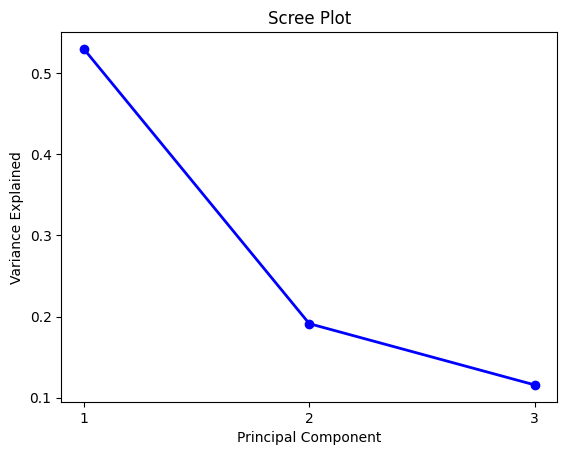

Principal Components: 
 [[0.06997157 0.3056296  0.31649996 0.19849478 0.09197023 0.30298761
  0.42626121 0.39586293 0.37681493 0.2171316  0.05141531 0.36287308]
 [0.75606402 0.39295893 0.13473003 0.16574894 0.12999734 0.12317309
  0.18412304 0.21445026 0.23680108 0.05120575 0.20065137 0.1319345 ]
 [0.1750338  0.39440763 0.06185747 0.07163428 0.10249042 0.14948484
  0.06529252 0.03157935 0.16214377 0.81043809 0.23518425 0.16830174]]
Explained Variance Ratio: 
 [0.52975966 0.19121722 0.11572562]
Loading Vectors: 
 [[-0.06422245 -0.41691537  0.07508661]
 [ 0.28051797  0.21668882  0.16919436]
 [ 0.29049518 -0.074294    0.02653584]
 [ 0.18218573 -0.09139872  0.03072992]
 [ 0.08441362 -0.07168426  0.0439667 ]
 [-0.27809305 -0.06792117  0.06412653]
 [-0.39123805  0.10153072  0.02800941]
 [-0.36333741  0.11825402  0.01354702]
 [ 0.34585446  0.1305789   0.069557  ]
 [ 0.19929128 -0.02823632 -0.34766457]
 [ 0.04719084  0.11064492 -0.10089016]
 [-0.33305812  0.07275246 -0.07219867]]


In [4]:
def pc(preprocessingData, numberOfComponent, concatData, frame):
    # fitting
    pca = PCA(n_components=numberOfComponent, whiten=True)
    principalComponent = pca.fit_transform(preprocessingData)
    
    # Explained variance
    PC_values = np.arange(pca.n_components_) + 1
    plt.plot(PC_values,
             pca.explained_variance_ratio_,
             'o-',
             linewidth=2,
             color='blue')
    plt.title('Scree Plot')
    plt.xticks([x for x in range(1, numberOfComponent+1)])
    plt.xlabel('Principal Component')
    plt.ylabel('Variance Explained')
    plt.show()
    
    # Components
    principalComponents = abs(pca.components_)
    print("Principal Components: \n", principalComponents)
    
    explainedVarianceRatio = pca.explained_variance_ratio_
    print("Explained Variance Ratio: \n", explainedVarianceRatio)
    
    loadingVectors = pca.components_.T * np.sqrt(pca.explained_variance_)
    print("Loading Vectors: \n", loadingVectors)
    
    principalComponentsData = pd.DataFrame(data=principalComponent, columns=['PC1', 'PC2', 'PC3'])
    principalComponentsDataframe = pd.concat([principalComponentsData, concatData[frame]], axis=1)
    principalComponentsDataframe.to_csv(f"TraceElement_PCA_{numberOfComponent}.csv")
    
    return principalComponentsDataframe, principalComponent, loadingVectors, explainedVarianceRatio
    
numberOfComponent = 3
principalComponentsDataframe, principalComponent, loadingVectors, explainedVarianceRatio = pc(preprocessingData, numberOfComponent, concatData, frame)

### Visualisation

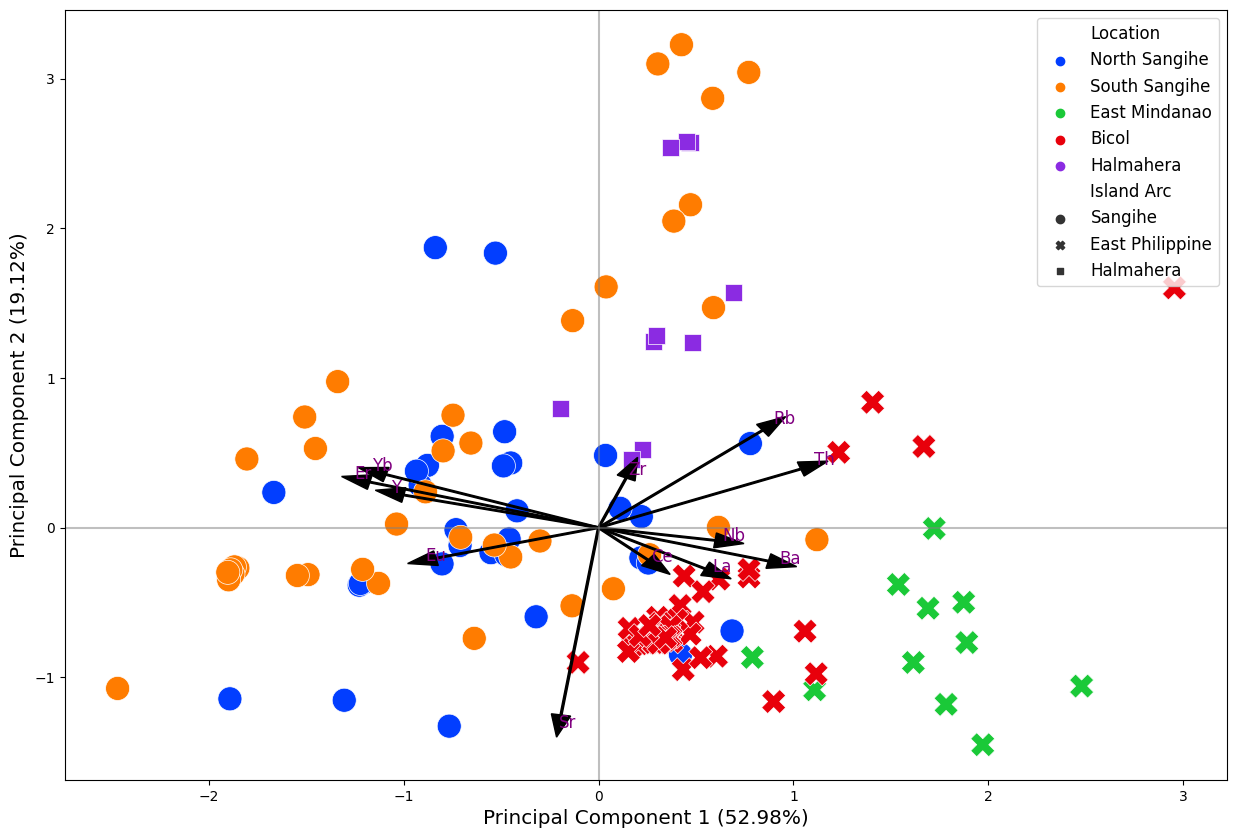

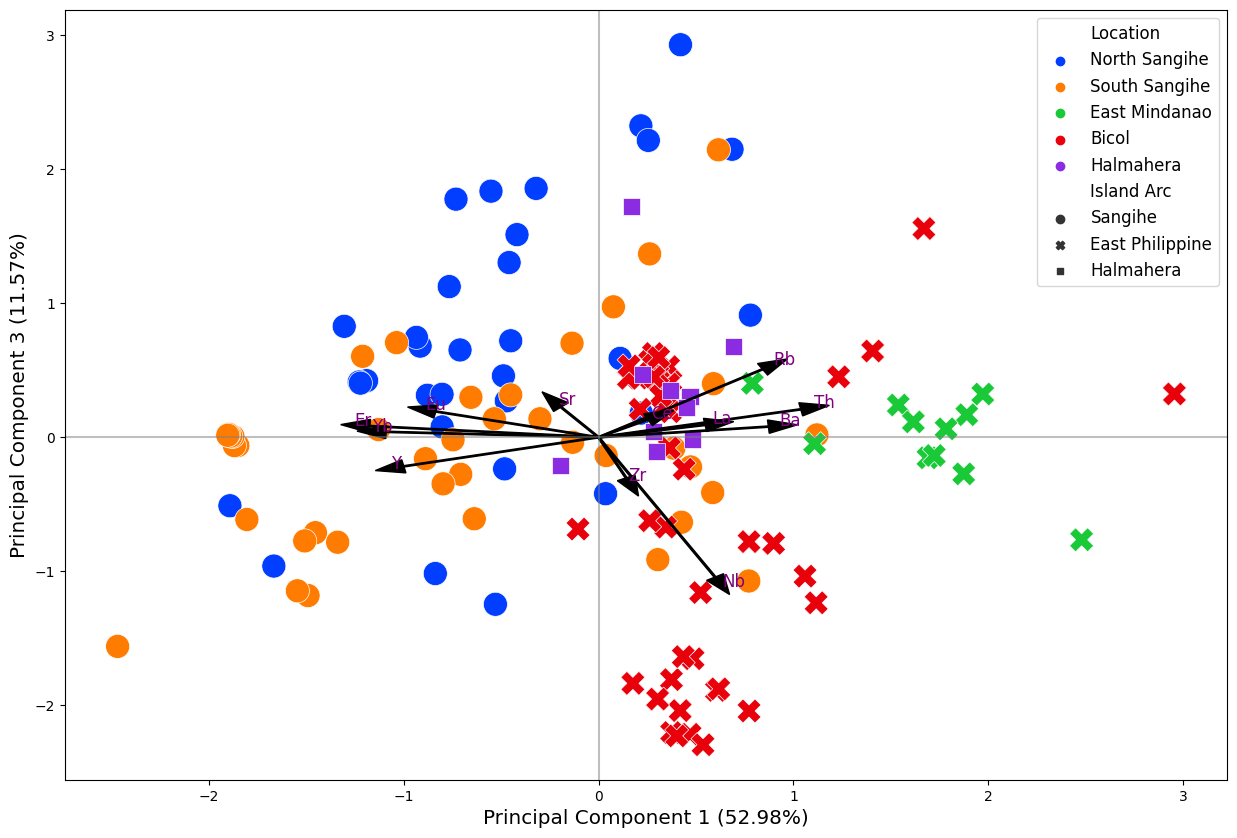

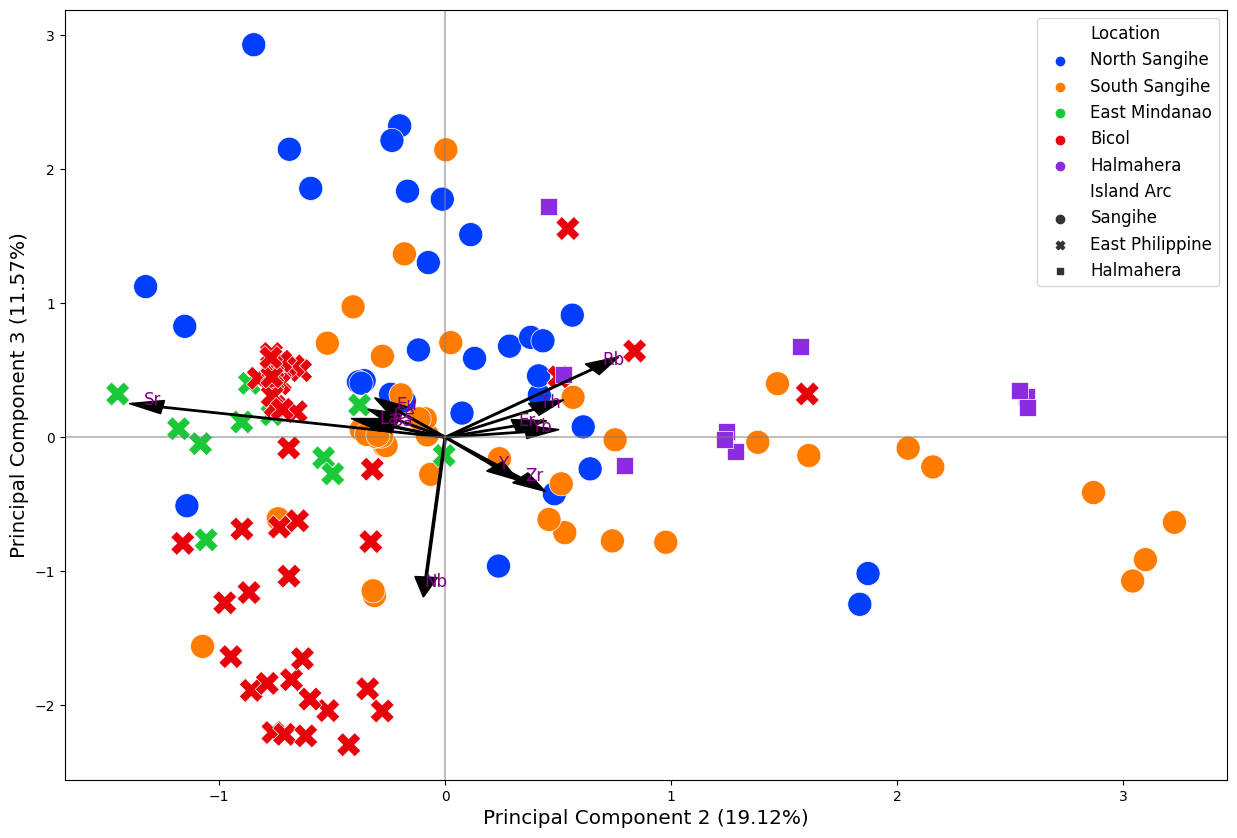

In [5]:
arrow_multiplier = 3
text_multiplier = 3.2

# arrow_multiplier = 1
# text_multiplier = 1

# PC1vsPC2
fig1, ax = plt.subplots(figsize=(15, 10))
sns.scatterplot(data=principalComponentsDataframe,
                edgecolors="black",
                linewidth=0.5,
                x="PC1",
                y="PC2",
                s=300,
                palette='bright',
                hue="Location",
                style="Island Arc")

plt.legend(fontsize="large", loc=1)
plt.xlabel(f'Principal Component 1 ({explainedVarianceRatio[0]*100:.2f}%)', fontsize="x-large")
plt.ylabel(f'Principal Component 2 ({explainedVarianceRatio[1]*100:.2f}%)', fontsize="x-large")
ax.axhline(y=0, color='gray', alpha=0.5)
ax.axvline(x=0, color='gray', alpha=0.5)
for i, feature in enumerate(elements):
    plt.arrow(0,
              0,  
              arrow_multiplier * loadingVectors[i, 0],
              arrow_multiplier * loadingVectors[i, 1],
              color='black',
              width=0.01,
              head_width=0.1)
    plt.text(text_multiplier * loadingVectors[i, 0],
             text_multiplier * loadingVectors[i, 1],
             feature,
             color="purple",
             fontsize="large")
plt.savefig(f'PCA_trace_{numberOfComponent}_1vs2.svg')

# PC1vsPC3
fig2, ax = plt.subplots(figsize=(15, 10))
sns.scatterplot(data=principalComponentsDataframe,
                edgecolors="black",
                linewidth=0.5,
                x="PC1",
                y="PC3",
                s=300,
                palette='bright',
                hue="Location",
                style="Island Arc")

plt.legend(fontsize="large", loc=1)
plt.xlabel(f'Principal Component 1 ({explainedVarianceRatio[0]*100:.2f}%)', fontsize="x-large")
plt.ylabel(f'Principal Component 3 ({explainedVarianceRatio[2]*100:.2f}%)', fontsize="x-large")
ax.axhline(y=0, color='gray', alpha=0.5)
ax.axvline(x=0, color='gray', alpha=0.5)
for i, feature in enumerate(elements):
    plt.arrow(0,
              0,  
              arrow_multiplier * loadingVectors[i, 0],
              arrow_multiplier * loadingVectors[i, 2],
              color='black',
              width=0.01,
              head_width=0.1)
    plt.text(text_multiplier * loadingVectors[i, 0],
             text_multiplier * loadingVectors[i, 2],
             feature,
             color="purple",
             fontsize="large")
plt.savefig(f'PCA_trace_{numberOfComponent}_1vs3.svg')

# PC2vsPC3
fig3, ax = plt.subplots(figsize=(15, 10))
sns.scatterplot(data=principalComponentsDataframe,
                edgecolors="black",
                linewidth=0.5,
                x="PC2",
                y="PC3",
                s=300,
                palette='bright',
                hue="Location",
                style="Island Arc")

plt.legend(fontsize="large", loc=1)
plt.xlabel(f'Principal Component 2 ({explainedVarianceRatio[1]*100:.2f}%)', fontsize="x-large")
plt.ylabel(f'Principal Component 3 ({explainedVarianceRatio[2]*100:.2f}%)', fontsize="x-large")
ax.axhline(y=0, color='gray', alpha=0.5)
ax.axvline(x=0, color='gray', alpha=0.5)
for i, feature in enumerate(elements):
    plt.arrow(0,
              0,  
              arrow_multiplier * loadingVectors[i, 1],
              arrow_multiplier * loadingVectors[i, 2],
              color='black',
              width=0.01,
              head_width=0.1)
    plt.text(text_multiplier * loadingVectors[i, 1],
             text_multiplier * loadingVectors[i, 2],
             feature,
             color="purple",
             fontsize="large")
plt.savefig(f'PCA_trace_{numberOfComponent}_2vs3.svg')

## Independent Component Analysis

In [6]:
def ic(whitenedData, concatData, frame, loadingVectors):
    ica = FastICA(whiten= False, max_iter=100000, random_state=12)
    icaData = ica.fit_transform(whitenedData)
    vectorData = ica.transform(loadingVectors)
    icaIndependentComponent = pd.DataFrame(data=icaData, columns=['IC1', 'IC2', 'IC3'])
    icaDataframe = pd.concat([icaIndependentComponent, concatData[frame]], axis=1)
    
    return icaIndependentComponent, icaDataframe, vectorData

icaIndependentComponent, pcIcAndOrginal, vectorData= ic(principalComponent, concatData, frame, loadingVectors)

In [7]:
vectorData

array([[-0.39198264,  0.16627502,  0.04778259],
       [ 0.32009501,  0.12459747,  0.19048822],
       [ 0.08858662,  0.28602221,  0.03090149],
       [ 0.01666825,  0.20314389,  0.03073147],
       [-0.01912251,  0.10980375,  0.04212873],
       [-0.20858014, -0.1997967 ,  0.05135025],
       [-0.12236138, -0.38561734,  0.02207233],
       [-0.09250286, -0.37085633,  0.0095082 ],
       [ 0.28837617,  0.2249877 ,  0.08788657],
       [ 0.10469879,  0.18205906, -0.3424582 ],
       [ 0.12539619, -0.01901162, -0.09253352],
       [-0.10927149, -0.32160711, -0.07785813]])

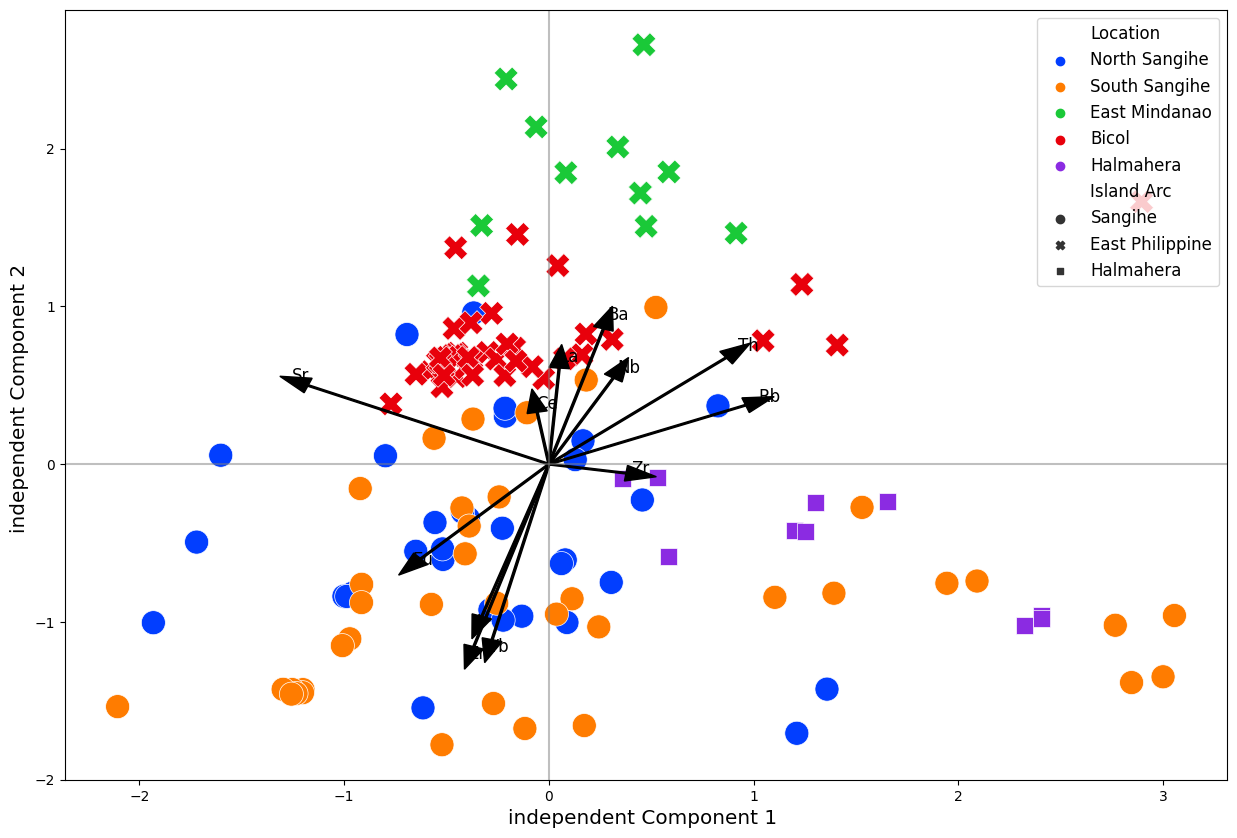

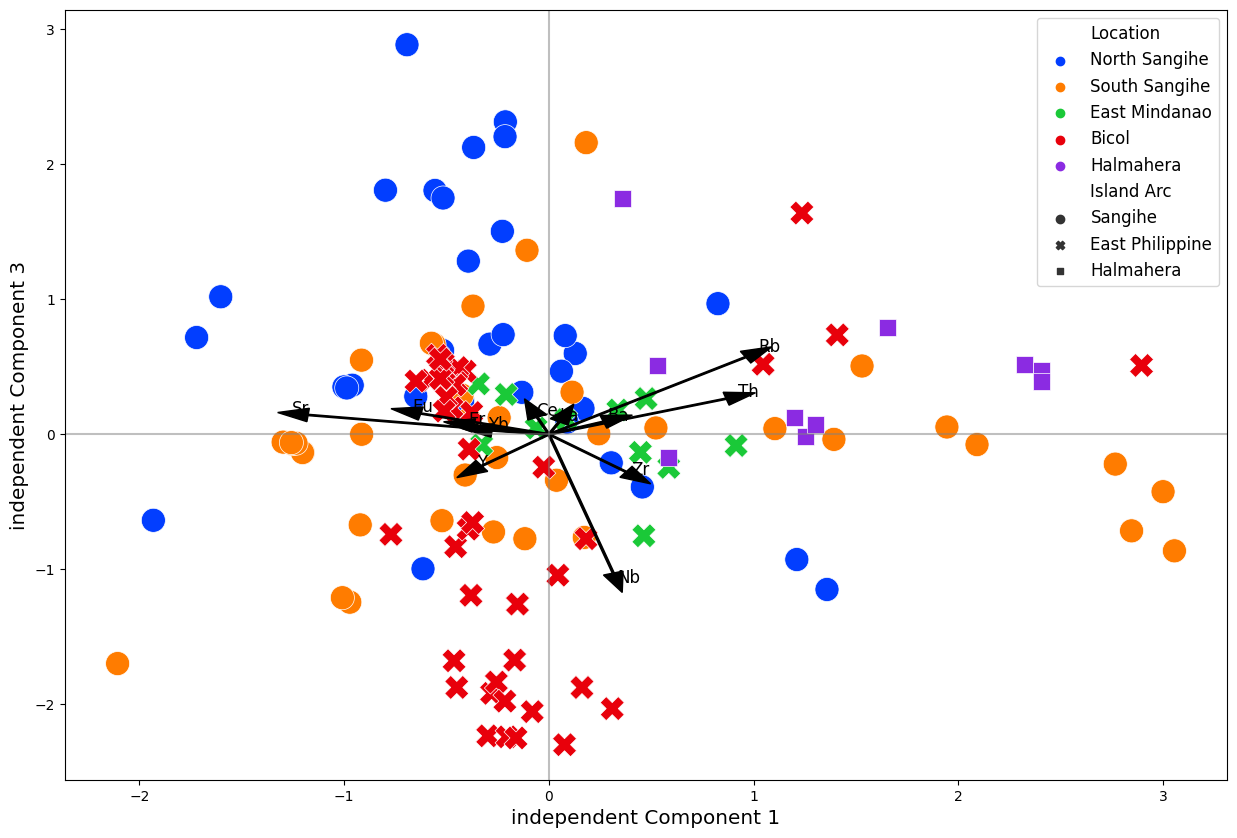

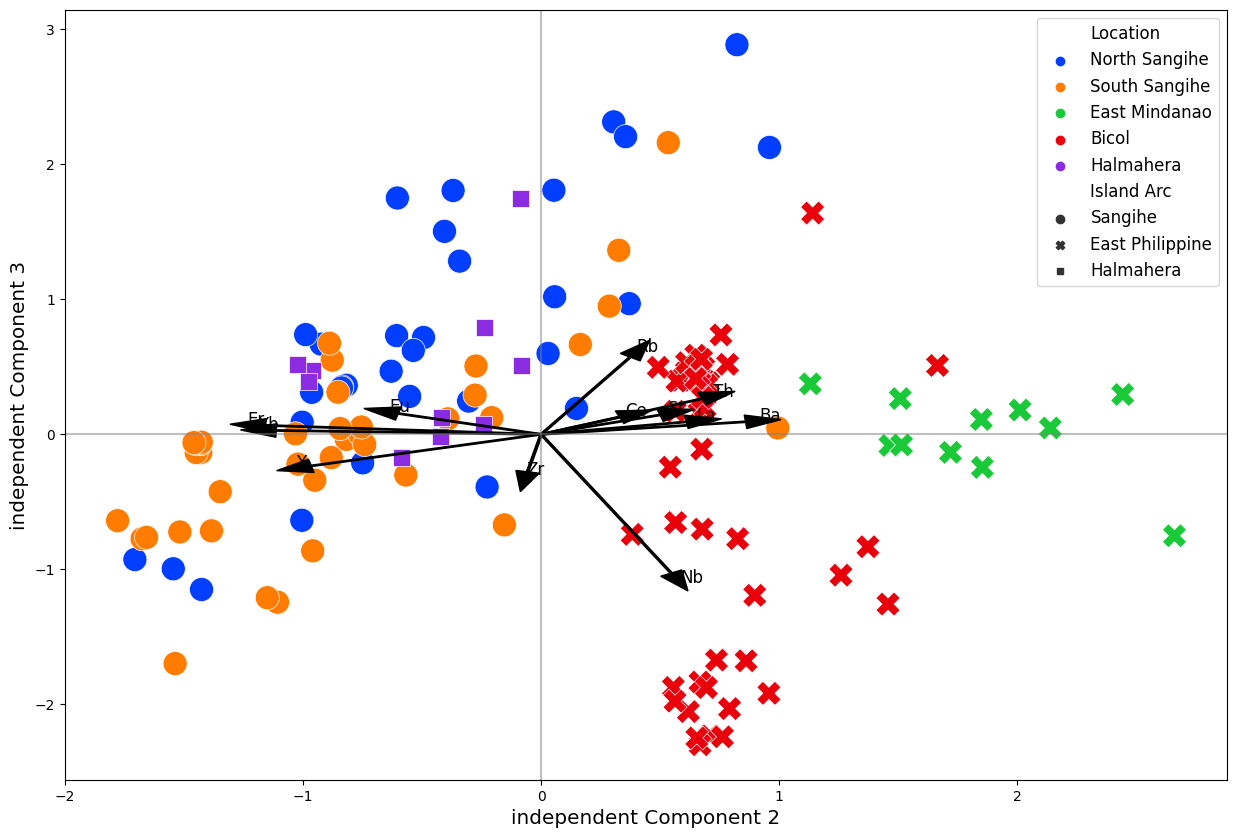

In [8]:
arrow_multiplier = 3
text_multiplier = 3.2

# IC1vsIC2
figx, ax = plt.subplots(figsize=(15, 10))
sns.scatterplot(data=pcIcAndOrginal,
                edgecolors="black",
                linewidth=0.5,
                x="IC1",
                y="IC2",
                s=300,
                palette='bright',
                hue="Location",
                style="Island Arc")
plt.legend(fontsize="large", loc=1)
plt.xlabel(f'independent Component 1 ', fontsize="x-large")
plt.ylabel(f'independent Component 2 ', fontsize="x-large")
for i, feature in enumerate(elements):
    plt.arrow(0,
              0,  
              arrow_multiplier * vectorData[i, 0],
              arrow_multiplier * vectorData[i, 1],
              color='black',
              width=0.01,
              head_width=0.1)
    plt.text(text_multiplier * vectorData[i, 0],
             text_multiplier * vectorData[i, 1],
             feature,
             fontsize="large")
ax.axhline(y=0, color='gray', alpha=0.5)
ax.axvline(x=0, color='gray', alpha=0.5)
plt.savefig(f'ICA_trace_{numberOfComponent}_1vs2.svg')
# IC1vsIC3
figy, ax = plt.subplots(figsize=(15, 10))
sns.scatterplot(data=pcIcAndOrginal,
                edgecolors="black",
                linewidth=0.5,
                x="IC1",
                y="IC3",
                s=300,
                palette='bright',
                hue="Location",
                style="Island Arc")
plt.legend(fontsize="large", loc=1)
plt.xlabel(f'independent Component 1', fontsize="x-large")
plt.ylabel(f'independent Component 3', fontsize="x-large")
for i, feature in enumerate(elements):
    plt.arrow(0,
              0,  
              arrow_multiplier * vectorData[i, 0],
              arrow_multiplier * vectorData[i, 2],
              color='black',
              width=0.01,
              head_width=0.1)
    plt.text(text_multiplier * vectorData[i, 0],
             text_multiplier * vectorData[i, 2],
             feature,
             fontsize="large")
ax.axhline(y=0, color='gray', alpha=0.5)
ax.axvline(x=0, color='gray', alpha=0.5)
plt.savefig(f'ICA_trace_{numberOfComponent}_1vs3.svg')
# IC2vsIC3
figz, ax = plt.subplots(figsize=(15, 10))
sns.scatterplot(data=pcIcAndOrginal,
                edgecolors="black",
                linewidth=0.5,
                x="IC2",
                y="IC3",
                s=300,
                palette='bright',
                hue="Location",
                style="Island Arc")
plt.legend(fontsize="large", loc=1)
plt.xlabel(f'independent Component 2', fontsize="x-large")
plt.ylabel(f'independent Component 3', fontsize="x-large")
for i, feature in enumerate(elements):
    plt.arrow(0,
              0,  
              arrow_multiplier * vectorData[i, 1],
              arrow_multiplier * vectorData[i, 2],
              color='black',
              width=0.01,
              head_width=0.1)
    plt.text(text_multiplier * vectorData[i, 1],
             text_multiplier * vectorData[i, 2],
             feature,
             fontsize="large")
ax.axhline(y=0, color='gray', alpha=0.5)
ax.axvline(x=0, color='gray', alpha=0.5)
plt.savefig(f'ICA_trace_{numberOfComponent}_2vs3.svg')

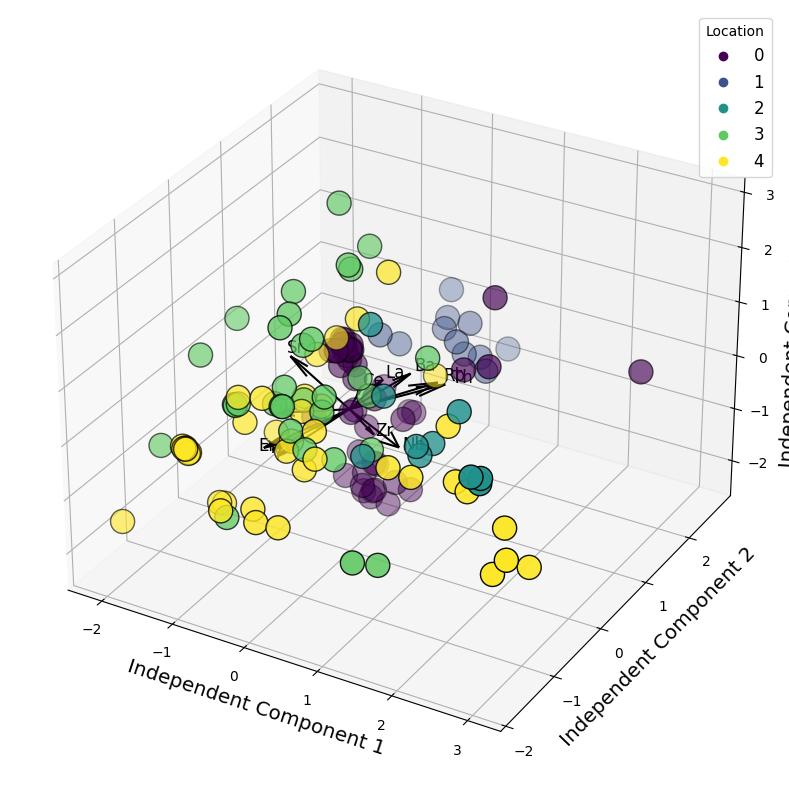

In [9]:
arrow_multiplier = 3
text_multiplier = 3.2

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for IC1, IC2, and IC3
scatter = ax.scatter(pcIcAndOrginal['IC1'],
                     pcIcAndOrginal['IC2'],
                     pcIcAndOrginal['IC3'],
                     s=300,
                     c=pcIcAndOrginal['Location'].astype('category').cat.codes, # For color based on 'Location'
                     edgecolor="black",
                     cmap='viridis')  # Use a colormap

# Plot arrows for each feature
for i, feature in enumerate(elements):
    ax.quiver(0, 0, 0,  # Start point of the arrow (origin)
              arrow_multiplier * vectorData[i, 0],  # x component
              arrow_multiplier * vectorData[i, 1],  # y component
              arrow_multiplier * vectorData[i, 2],  # z component
              color='black')
    ax.text(text_multiplier * vectorData[i, 0],
            text_multiplier * vectorData[i, 1],
            text_multiplier * vectorData[i, 2],
            feature,
            fontsize="large")

# Axis labels
ax.set_xlabel('Independent Component 1', fontsize="x-large")
ax.set_ylabel('Independent Component 2', fontsize="x-large")
ax.set_zlabel('Independent Component 3', fontsize="x-large")

# Add legend
legend = ax.legend(*scatter.legend_elements(), title="Location", fontsize="large", loc='upper right')

# Save the figure
plt.savefig(f'ICA_trace_{numberOfComponent}_3D.svg')
plt.show()

In [10]:
# Define a mapping of Location categories to symbols
location_symbol_mapping = {
    'Sangihe': 'circle',
    'East Philippine': 'square',
    'Halmahera': 'diamond',
}

# Apply the mapping to the 'Location' column
pcIcAndOrginal['location_symbol'] = pcIcAndOrginal['Island Arc'].map(location_symbol_mapping)

arrow_multiplier = 9
text_multiplier = 9.2


# Create 3D scatter plot
fig = go.Figure()

# Scatter plot for IC1, IC2, and IC3 with different symbols based on "Location"
fig.add_trace(go.Scatter3d(
    x=pcIcAndOrginal['IC1'],
    y=pcIcAndOrginal['IC2'],
    z=pcIcAndOrginal['IC3'],
    mode='markers',
    marker=dict(
        size=8,
        color=pcIcAndOrginal['Location'].astype('category').cat.codes,  # Color by 'Location'
        colorscale='rdylbu',  # Color scale
        opacity=0.8,
        symbol=pcIcAndOrginal['location_symbol'],  # Use mapped symbols for locations
    ),
    text=pcIcAndOrginal['Island Arc'],  # Text when hovering over points
    hoverinfo='text',
    name='Data Points',  # Name for the legend
))

# Add lines for each feature with a legend
for i, feature in enumerate(elements):
    fig.add_trace(go.Scatter3d(
        x=[0, arrow_multiplier * vectorData[i, 0]],  # Line from origin to scaled vector
        y=[0, arrow_multiplier * vectorData[i, 1]],  # Line from origin to scaled vector
        z=[0, arrow_multiplier * vectorData[i, 2]],  # Line from origin to scaled vector
        mode='lines',
        line=dict(color='black', width=4),  # Customize line color and width
        hoverinfo='none',  # Disable hover info for lines
        showlegend=True,
        name=feature,  # Feature name for the legend
    ))
    # Add feature names as text labels
    fig.add_trace(go.Scatter3d(
        x=[text_multiplier * vectorData[i, 0]],
        y=[text_multiplier * vectorData[i, 1]],
        z=[text_multiplier * vectorData[i, 2]],
        mode='text',
        text=[feature],
        textposition='middle right',
        showlegend=False,
    ))

# Customize layout with legend
fig.update_layout(
    scene=dict(
        xaxis_title='Independent Component 1',
        yaxis_title='Independent Component 2',
        zaxis_title='Independent Component 3',
    ),
    margin=dict(l=0, r=0, b=0, t=0),
    hovermode='closest',
    legend=dict(
        title='Legend',
        x=0.02, y=0.98,
        bgcolor='rgba(255, 255, 255, 0.8)',
    ),
    showlegend=False,
)

# Show plot
display(fig)

## K-Means Clustering

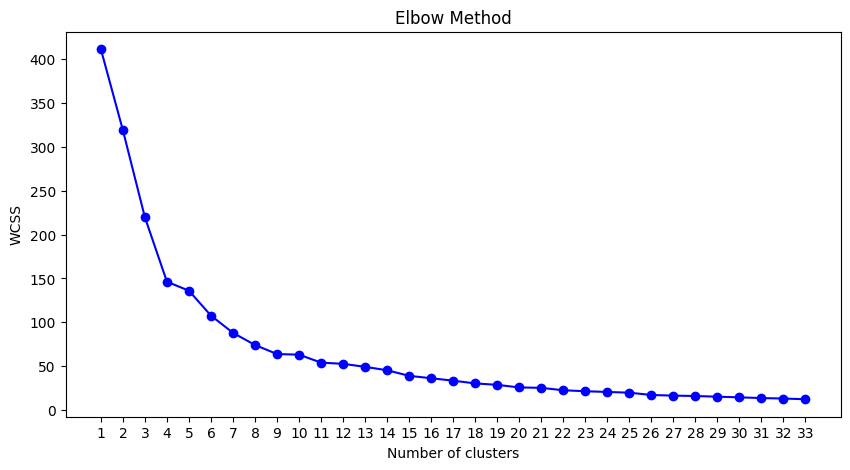

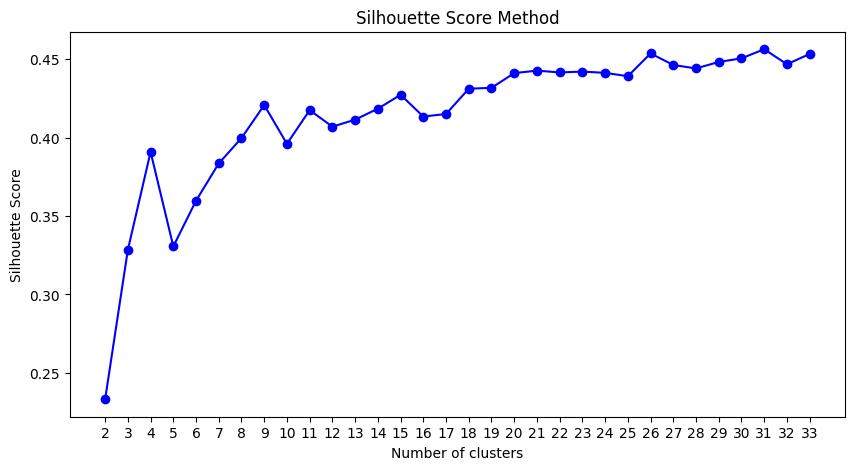

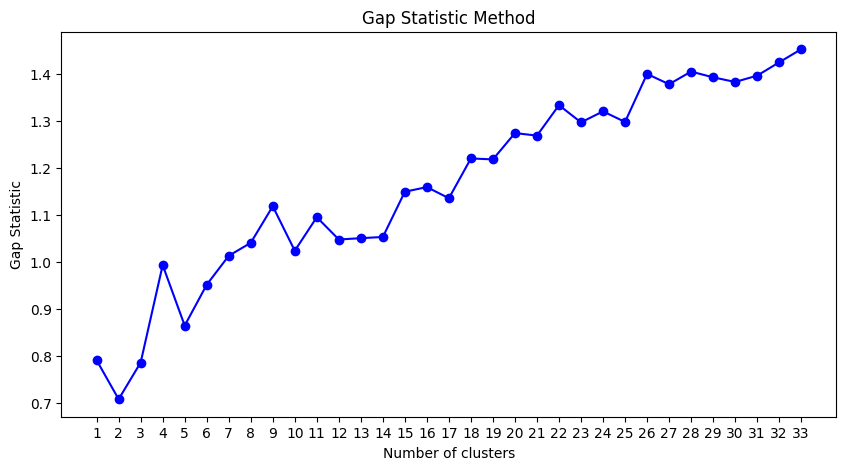

Optimal number of clusters based on Gap Statistic: 33


In [11]:
# Retrieve the first 3 column
X = principalComponentsDataframe.iloc[:, :3].values

# Elbow Method
def elbow_method(X):
    wcss = []
    k_values = range(1, 34)
    for k in k_values:
        kmeans = KMeans(init="k-means++", n_clusters=k, random_state=42, n_init='auto')
        kmeans.fit(X)
        wcss.append(kmeans.inertia_)
    
    plt.figure(figsize=(10, 5))
    plt.plot(k_values, wcss, 'bo-')
    plt.title('Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.xticks(k_values)
    plt.show()

# Silhouette Score Method
def silhouette_method(X):
    silhouette_avg = []
    k_values = range(2, 34)
    for k in k_values:
        kmeans = KMeans(init="k-means++", n_clusters=k, random_state=42, n_init='auto')
        labels = kmeans.fit_predict(X)
        silhouette_avg.append(silhouette_score(X, labels))
    
    plt.figure(figsize=(10, 5))
    plt.plot(k_values, silhouette_avg, 'bo-')
    plt.title('Silhouette Score Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Score')
    plt.xticks(k_values)
    plt.show()

# Gap Statistic Method
def gap_statistic_method(X, n_refs=10, max_clusters=33):
    def compute_wcss(X, n_clusters):
        kmeans = KMeans(init="k-means++", n_clusters=n_clusters, random_state=42, n_init='auto')
        kmeans.fit(X)
        return kmeans.inertia_

    def create_reference_data(X):
        min_vals = np.min(X, axis=0)
        max_vals = np.max(X, axis=0)
        return np.random.uniform(min_vals, max_vals, X.shape)

    gaps = []
    for k in range(1, max_clusters + 1):
        actual_wcss = compute_wcss(X, k)
        ref_wcss = np.zeros(n_refs)
        for i in range(n_refs):
            X_ref = create_reference_data(X)
            ref_wcss[i] = compute_wcss(X_ref, k)
        
        gap = np.log(np.mean(ref_wcss)) - np.log(actual_wcss)
        gaps.append(gap)

    optimal_k = np.argmax(gaps) + 1  # +1 because index starts from 0
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, max_clusters + 1), gaps, 'bo-')
    plt.title('Gap Statistic Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('Gap Statistic')
    plt.xticks(range(1, max_clusters+1))
    plt.show()

    return optimal_k

# Run the methods
elbow_method(X)
silhouette_method(X)
optimal_k = gap_statistic_method(X)
print(f'Optimal number of clusters based on Gap Statistic: {optimal_k}')

silhouette score KCA: 0.3845155560828022


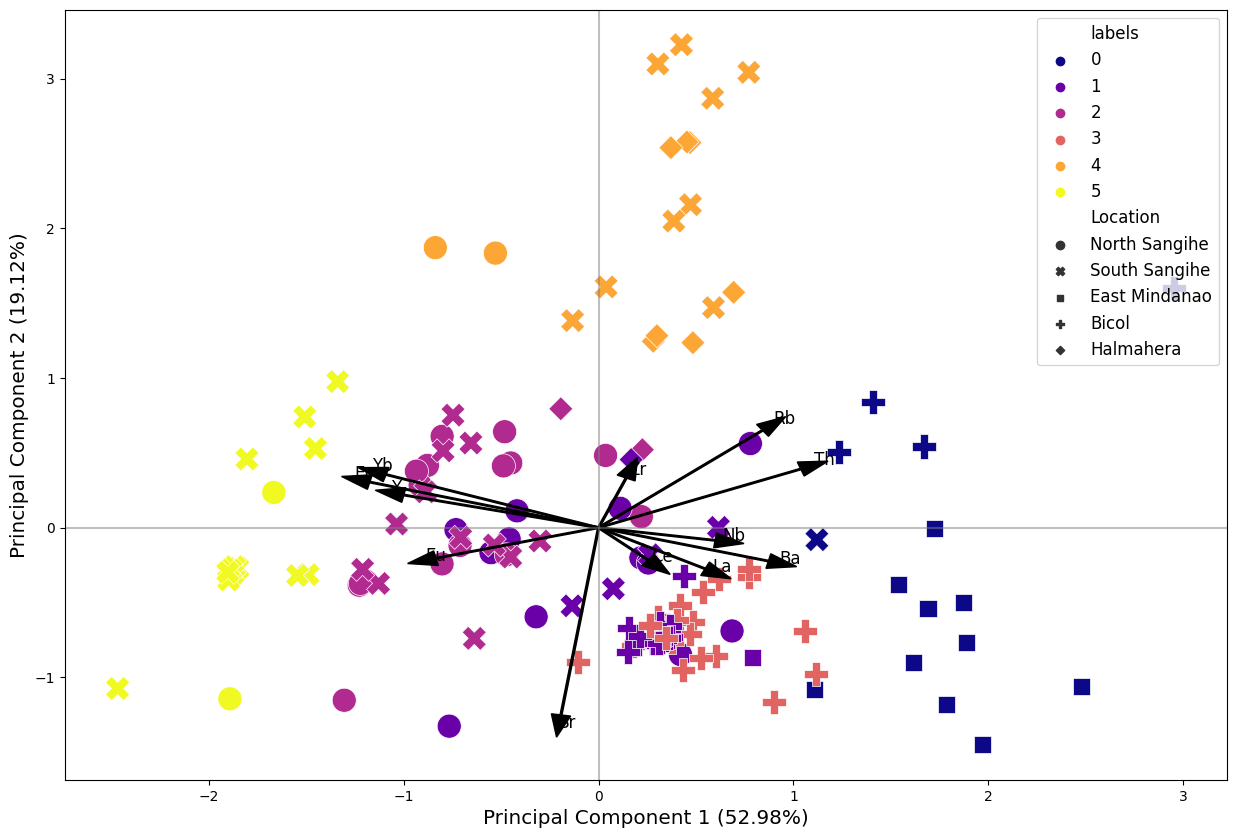

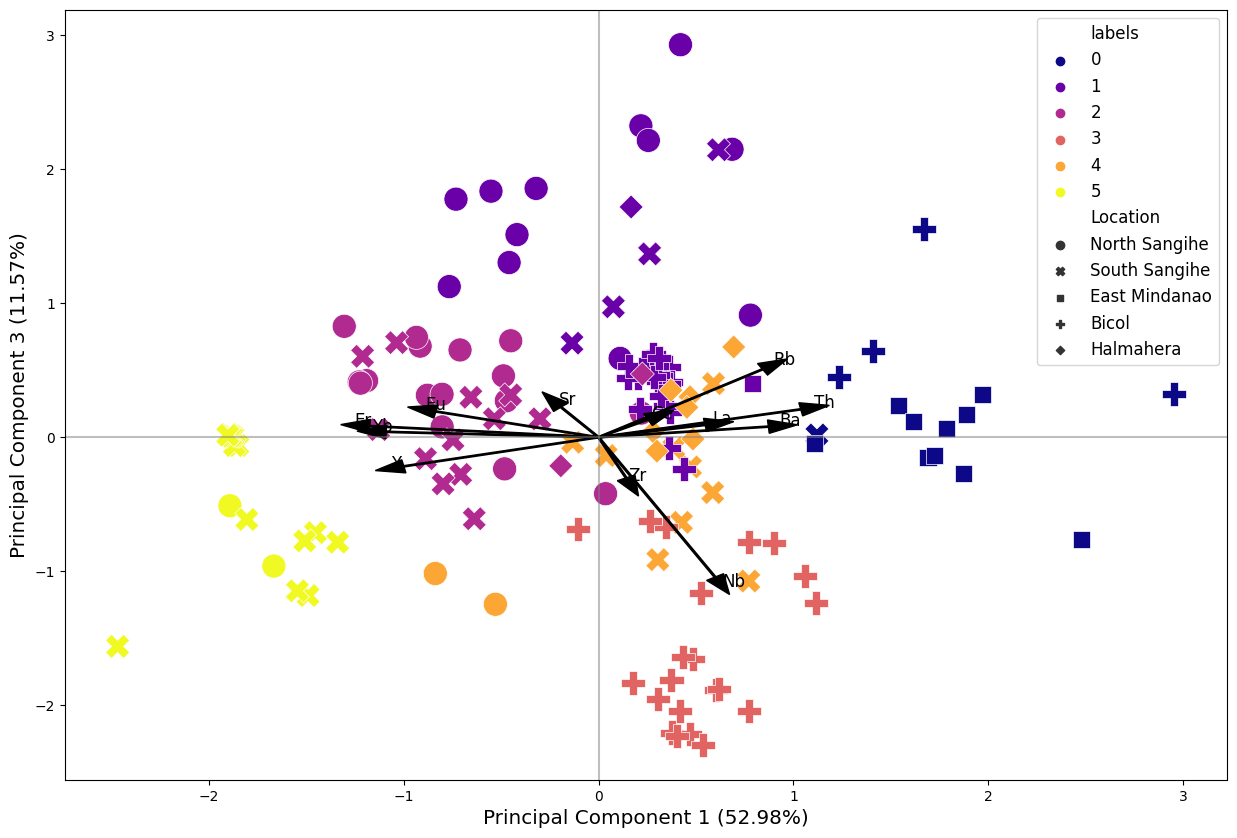

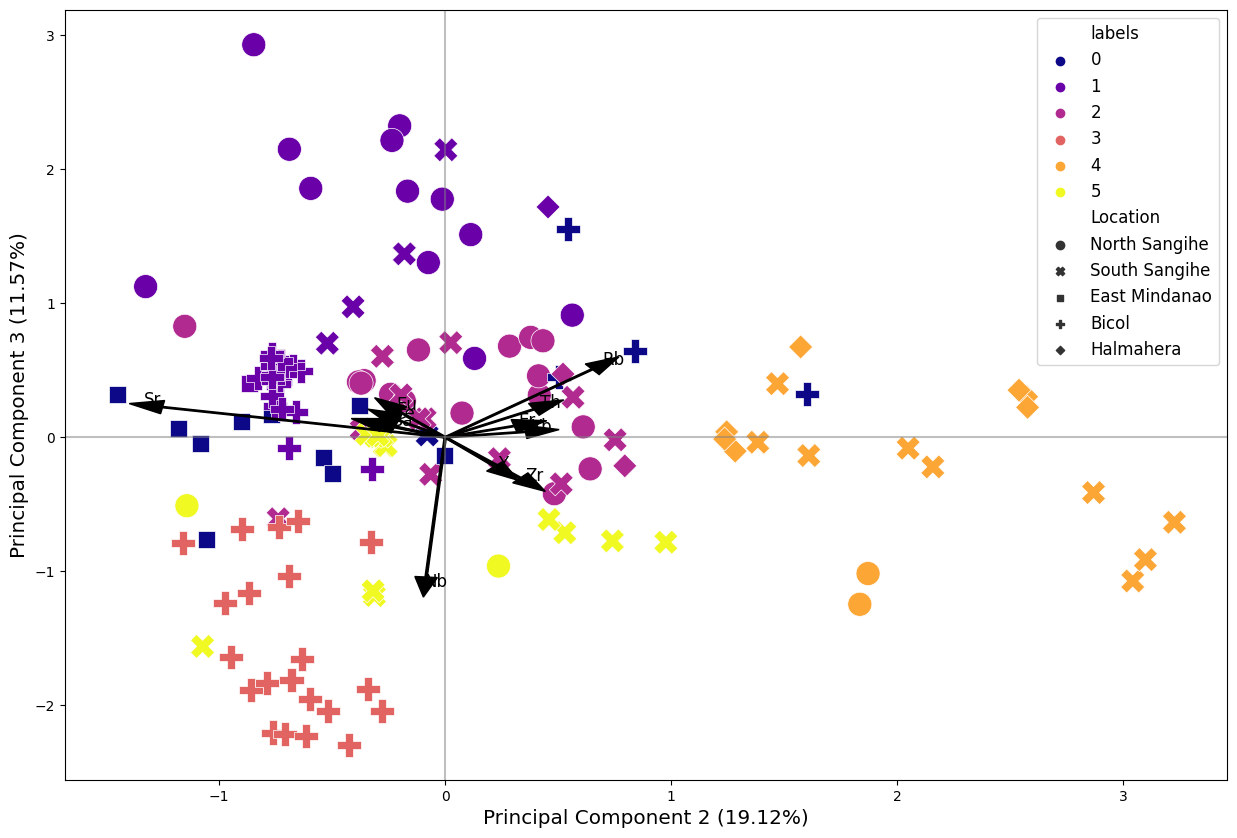

In [12]:
def kmc(principalComponentsDataframe, cluster, explainedVarianceRatio, ratio, frame, loadingVectors):
    X = principalComponentsDataframe.iloc[:, 0:3].values
    dataFrame = principalComponentsDataframe[frame]
    
    kmeans = KMeans(init="k-means++", n_clusters=cluster, random_state=12, n_init='auto')
    labels = kmeans.fit_predict(X)
    score = silhouette_score(X, labels)
    print(f'silhouette score KCA: {score}')

    principalComponentsDataframe["labels"] = labels

    # Plot dataset
    fig, ax = plt.subplots(figsize=(15, 10))
    sns.scatterplot(x="PC1",
                    y="PC2",
                    edgecolors="black",
                    linewidth=0.5,
                    s=300,
                    data=principalComponentsDataframe,
                    hue="labels",
                    style="Location",
                    palette="plasma")
    plt.legend(fontsize="large", loc=1)
    plt.xlabel(f'Principal Component 1 ({explainedVarianceRatio[0]*100:.2f}%)', fontsize="x-large")
    plt.ylabel(f'Principal Component 2 ({explainedVarianceRatio[1]*100:.2f}%)', fontsize="x-large")
    ax.axhline(y=0, color='gray', alpha=0.5)
    ax.axvline(x=0, color='gray', alpha=0.5)
    for i, feature in enumerate(elements):
        plt.arrow(0,
                  0,
                  3 * loadingVectors[i, 0],
                  3 * loadingVectors[i, 1],
                  color='black',
                  width=0.01,
                  head_width=0.1)
        plt.text(3.2 * loadingVectors[i, 0],
                 3.2 * loadingVectors[i, 1],
                 feature,
                 fontsize="large")
    plt.savefig(f'KMC_trace_PC1_vs_PC2_{score}_{cluster}.svg')

    fig2, ax = plt.subplots(figsize=(15, 10))
    sns.scatterplot(x="PC1",
                    y="PC3",
                    edgecolors="black",
                    linewidth=0.5,
                    s=300,
                    data=principalComponentsDataframe,
                    hue="labels",
                    style="Location",
                    palette="plasma")
    plt.legend(fontsize="large", loc=1)
    plt.xlabel(f'Principal Component 1 ({explainedVarianceRatio[0]*100:.2f}%)', fontsize="x-large")
    plt.ylabel(f'Principal Component 3 ({explainedVarianceRatio[2]*100:.2f}%)', fontsize="x-large")
    ax.axhline(y=0, color='gray', alpha=0.5)
    ax.axvline(x=0, color='gray', alpha=0.5)
    for i, feature in enumerate(elements):
        plt.arrow(0,
                  0,
                  3 * loadingVectors[i, 0],
                  3 * loadingVectors[i, 2],
                  color='black',
                  width=0.01,
                  head_width=0.1)
        plt.text(3.2 * loadingVectors[i, 0],
                 3.2 * loadingVectors[i, 2],
                 feature,
                 fontsize="large")
    plt.savefig(f'KMC_trace_PC1_vs_PC3_{score}_{cluster}.svg')

    fig3, ax = plt.subplots(figsize=(15, 10))
    sns.scatterplot(x="PC2",
                    y="PC3",
                    edgecolors="black",
                    linewidth=0.5,
                    s=300,
                    data=principalComponentsDataframe,
                    hue="labels",
                    style="Location",
                    palette="plasma")
    plt.legend(fontsize="large", loc=1)
    plt.xlabel(f'Principal Component 2 ({explainedVarianceRatio[1]*100:.2f}%)', fontsize="x-large")
    plt.ylabel(f'Principal Component 3 ({explainedVarianceRatio[2]*100:.2f}%)', fontsize="x-large")
    ax.axhline(y=0, color='gray', alpha=0.5)
    ax.axvline(x=0, color='gray', alpha=0.5)
    for i, feature in enumerate(elements):
        plt.arrow(0,
                  0,
                  3 * loadingVectors[i, 1],
                  3 * loadingVectors[i, 2],
                  color='black',
                  width=0.01,
                  head_width=0.1)
        plt.text(3.2 * loadingVectors[i, 1],
                 3.2 * loadingVectors[i, 2],
                 feature,
                 fontsize="large")
    plt.savefig(f'KMC_trace_PC2_vs_PC3_{score}_{cluster}.svg')
    
    return principalComponentsDataframe
    
cluster = 6
labelDataframe = kmc(principalComponentsDataframe, cluster, explainedVarianceRatio, elements, frame, loadingVectors)

In [13]:
pcAndOriginal = pd.concat([labelDataframe, concatData[elements]], axis=1, join='inner')
pcIcAndOrginal = pd.concat([pcAndOriginal, pcIcAndOrginal[["IC1", "IC2", "IC3"]]], axis=1, join='inner')
pcIcAndOrginal

PC1       PC2       PC3       Location  Longitude  Latitude  \
0   -0.552136 -0.166807  1.836955  North Sangihe    125.800     4.500   
1   -0.458999 -0.074990  1.304177  North Sangihe    125.700     4.233   
2   -0.529301  1.834104 -1.246265  North Sangihe    125.716     3.866   
3   -0.878332  0.415956  0.313675  North Sangihe    125.583     3.783   
4   -0.418545  0.112699  1.512626  North Sangihe    125.583     3.783   
..        ...       ...       ...            ...        ...       ...   
133  0.693484  1.572232  0.674178      Halmahera    127.330     0.800   
134  0.224865  0.520912  0.472374      Halmahera    127.350     0.300   
135  0.299575  1.282749 -0.103452      Halmahera    127.350     0.300   
136  0.484314  1.235928 -0.013100      Halmahera    127.350     0.300   
137  0.167172  0.454837  1.719114      Halmahera    127.350     0.300   

                  AGE         Sample Name Island Arc  labels  ...        Eu  \
0    PLIOCENE [16735]  s_PJ-40-78 [16735]    Sangihe       1  ...  0.387568   
1    PLIOCENE [16735]  s_PJ-43-78 [16735]    Sangihe       1  ...  0.286866   
2    PLIOCENE [16735]  s_PJ-45-78 [16735]    Sangihe       4  ...  0.221200   
3    PLIOCENE [16735]    s_PBUANG [16735]    Sangihe       2  ...  0.257825   
4    PLIOCENE [16735]   s_PJ-5-78 [16735]    Sangihe       1  ...  0.314496   
..                ...                 ...        ...     ...  ...       ...   
133               NaN        s_GL [25001]  Halmahera       4  ... -0.028485   
134               NaN       s_MK1 [25001]  Halmahera       2  ...  0.134601   
135               NaN       s_MK2 [25001]  Halmahera       4  ... -0.077697   
136               NaN       s_MK3 [25001]  Halmahera       4  ... -0.107032   
137               NaN       s_MK4 [25001]  Halmahera       1  ...  0.076469   

           Er        Yb        Th        Nb        Zr         Y       IC1  \
0    0.308690  0.254873 -0.413153 -0.870201 -0.110410  0.181223 -0.556485   
1    0.292747  0.251508 -0.291449 -0.733261 -0.007072  0.169978 -0.393659   
2    0.470382  0.527006 -0.313693  0.053677  0.594235  0.271216  1.357815   
3    0.490972  0.485924 -0.516492 -0.490717  0.090548  0.437412 -0.132409   
4    0.308462  0.262250 -0.307910 -0.644128 -0.218868  0.159787 -0.227443   
..        ...       ...       ...       ...       ...       ...       ...   
133 -0.094079  0.037949  0.784148 -0.340112  0.059147  0.012113  1.651776   
134 -0.019706 -0.000321  0.431778 -0.323646 -0.025183  0.193586  0.527887   
135  0.080834  0.058451  0.417464 -0.146565  0.237111  0.194043  1.251243   
136 -0.095104  0.005134  0.388129 -0.136680  0.265484  0.185159  1.302985   
137 -0.064501  0.044833  0.498209 -0.950363  0.023572  0.281431  0.357409   

          IC2       IC3  
0   -0.369754  1.805738  
1   -0.342347  1.282580  
2   -1.426019 -1.148949  
3   -0.963614  0.311118  
4   -0.405981  1.503119  
..        ...       ...  
133 -0.238316  0.788791  
134 -0.081657  0.509626  
135 -0.424270 -0.016608  
136 -0.242169  0.076377  
137 -0.088386  1.747748  

[138 rows x 25 columns]

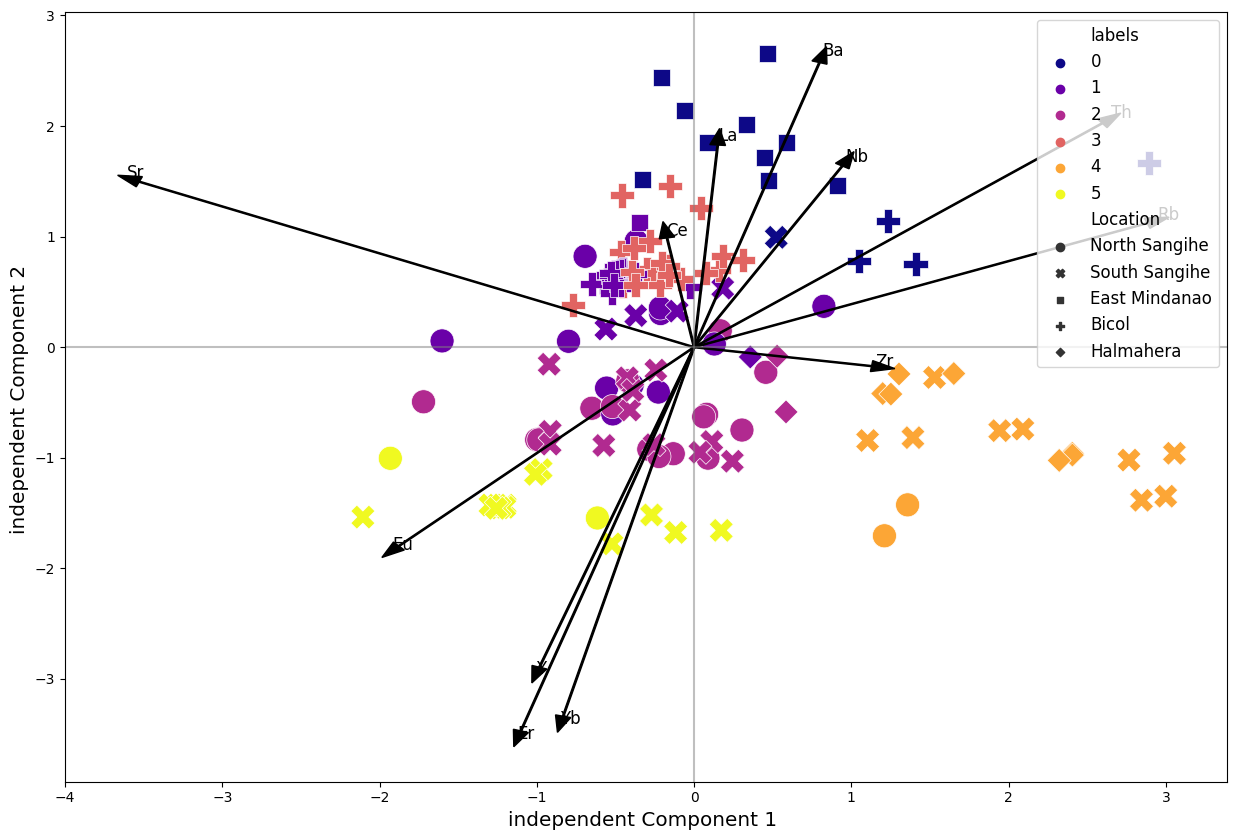

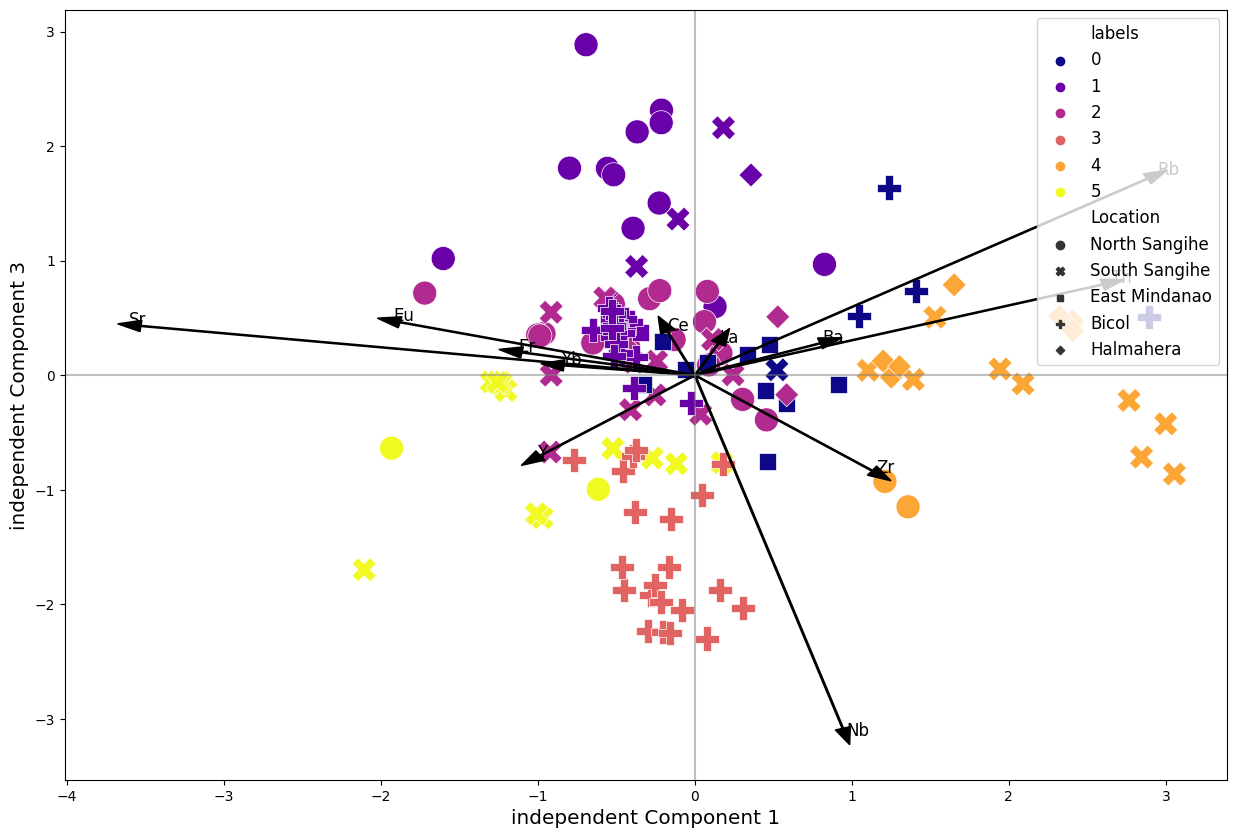

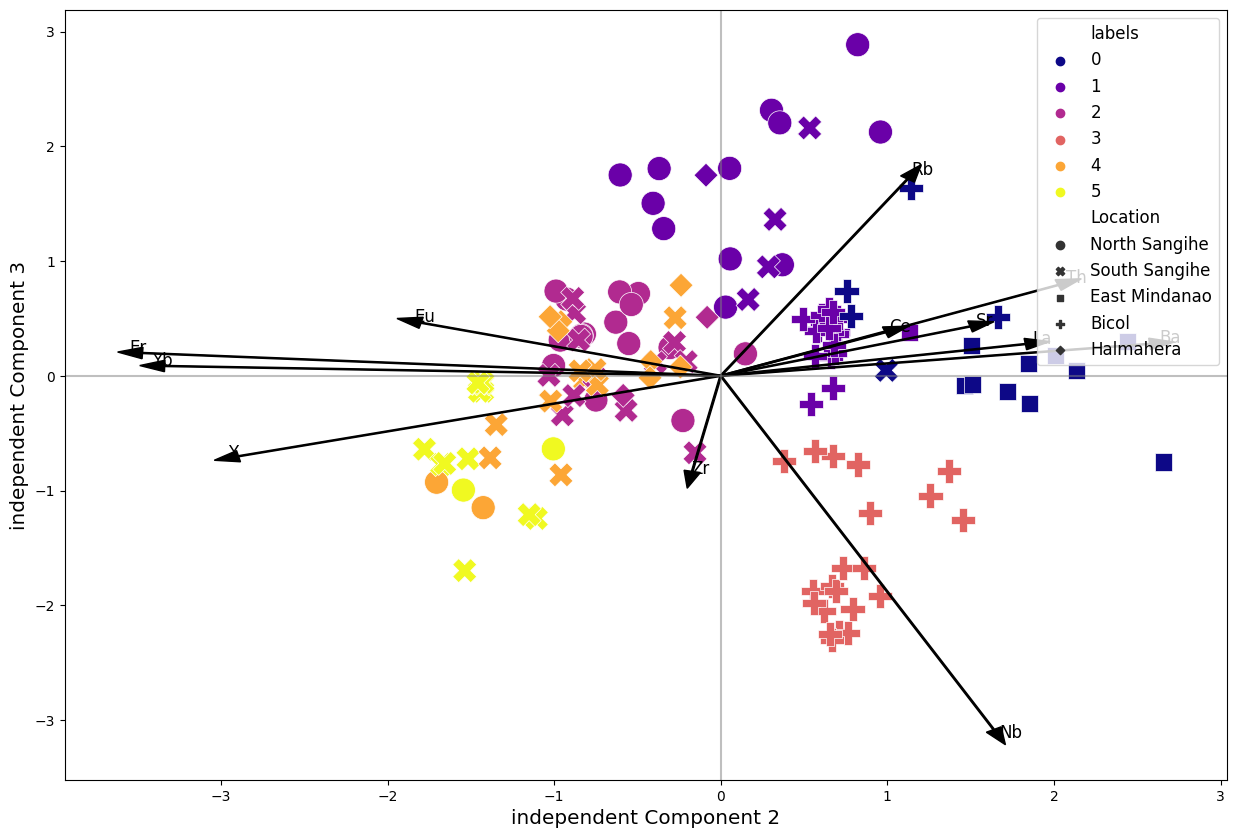

In [14]:
# ICA + Label
# IC1vsIC2
figx, ax = plt.subplots(figsize=(15, 10))
sns.scatterplot(data=pcIcAndOrginal,
                edgecolors="black",
                linewidth=0.5,
                x="IC1",
                y="IC2",
                s=300,
                palette='plasma',
                style="Location",
                hue="labels")
plt.legend(fontsize="large", loc=1)
plt.xlabel(f'independent Component 1 ', fontsize="x-large")
plt.ylabel(f'independent Component 2 ', fontsize="x-large")
for i, feature in enumerate(elements):
    plt.arrow(0,
              0,  
              arrow_multiplier * vectorData[i, 0],
              arrow_multiplier * vectorData[i, 1],
              color='black',
              width=0.01,
              head_width=0.1)
    plt.text(text_multiplier * vectorData[i, 0],
             text_multiplier * vectorData[i, 1],
             feature,
             fontsize="large")
ax.axhline(y=0, color='gray', alpha=0.5)
ax.axvline(x=0, color='gray', alpha=0.5)
plt.savefig(f'ICA_label_trace_{numberOfComponent}_1vs2.svg')
# IC1vsIC3
figy, ax = plt.subplots(figsize=(15, 10))
sns.scatterplot(data=pcIcAndOrginal,
                edgecolors="black",
                linewidth=0.5,
                x="IC1",
                y="IC3",
                s=300,
                palette='plasma',
                style="Location",
                hue="labels")
plt.legend(fontsize="large", loc=1)
plt.xlabel(f'independent Component 1', fontsize="x-large")
plt.ylabel(f'independent Component 3', fontsize="x-large")
for i, feature in enumerate(elements):
    plt.arrow(0,
              0,  
              arrow_multiplier * vectorData[i, 0],
              arrow_multiplier * vectorData[i, 2],
              color='black',
              width=0.01,
              head_width=0.1)
    plt.text(text_multiplier * vectorData[i, 0],
             text_multiplier * vectorData[i, 2],
             feature,
             fontsize="large")
ax.axhline(y=0, color='gray', alpha=0.5)
ax.axvline(x=0, color='gray', alpha=0.5)
plt.savefig(f'ICA_label_trace_{numberOfComponent}_1vs3.svg')
# IC2vsIC3
figz, ax = plt.subplots(figsize=(15, 10))
sns.scatterplot(data=pcIcAndOrginal,
                edgecolors="black",
                linewidth=0.5,
                x="IC2",
                y="IC3",
                s=300,
                palette='plasma',
                style="Location",
                hue="labels")
plt.legend(fontsize="large", loc=1)
plt.xlabel(f'independent Component 2', fontsize="x-large")
plt.ylabel(f'independent Component 3', fontsize="x-large")
for i, feature in enumerate(elements):
    plt.arrow(0,
              0,  
              arrow_multiplier * vectorData[i, 1],
              arrow_multiplier * vectorData[i, 2],
              color='black',
              width=0.01,
              head_width=0.1)
    plt.text(text_multiplier * vectorData[i, 1],
             text_multiplier * vectorData[i, 2],
             feature,
             fontsize="large")
ax.axhline(y=0, color='gray', alpha=0.5)
ax.axvline(x=0, color='gray', alpha=0.5)
plt.savefig(f'ICA_label_trace_{numberOfComponent}_2vs3.svg')

In [15]:
# Define a mapping of Location categories to symbols
location_symbol_mapping = {
    'Sangihe': 'circle',
    'East Philippine': 'square',
    'Halmahera': 'diamond',
}

# Apply the mapping to the 'Location' column
pcIcAndOrginal['location_symbol'] = pcIcAndOrginal['Island Arc'].map(location_symbol_mapping)

arrow_multiplier = 9
text_multiplier = 9.2

# Create 3D scatter plot
fig = go.Figure()

# Scatter plot for IC1, IC2, and IC3 with different symbols based on "Location"
fig.add_trace(go.Scatter3d(
    x=pcIcAndOrginal['IC1'],
    y=pcIcAndOrginal['IC2'],
    z=pcIcAndOrginal['IC3'],
    mode='markers',
    marker=dict(
        size=8,
        color=pcIcAndOrginal['labels'].astype('category').cat.codes,  # Color by 'Location'
        colorscale='rdylbu',  # Color scale
        opacity=0.8,
        symbol=pcIcAndOrginal['location_symbol'],  # Use mapped symbols for locations
    ),
    text=pcIcAndOrginal['Island Arc'],  # Text when hovering over points
    hoverinfo='text',
    name='Data Points',  # Name for the legend
))

# Add lines for each feature with a legend
for i, feature in enumerate(elements):
    fig.add_trace(go.Scatter3d(
        x=[0, arrow_multiplier * vectorData[i, 0]],  # Line from origin to scaled vector
        y=[0, arrow_multiplier * vectorData[i, 1]],  # Line from origin to scaled vector
        z=[0, arrow_multiplier * vectorData[i, 2]],  # Line from origin to scaled vector
        mode='lines',
        line=dict(color='black', width=4),  # Customize line color and width
        hoverinfo='none',  # Disable hover info for lines
        showlegend=True,
        name=feature,  # Feature name for the legend
    ))
    # Add feature names as text labels
    fig.add_trace(go.Scatter3d(
        x=[text_multiplier * vectorData[i, 0]],
        y=[text_multiplier * vectorData[i, 1]],
        z=[text_multiplier * vectorData[i, 2]],
        mode='text',
        text=[feature],
        textposition='middle right',
        showlegend=False,
    ))

# Customize layout with legend
fig.update_layout(
    scene=dict(
        xaxis_title='Independent Component 1',
        yaxis_title='Independent Component 2',
        zaxis_title='Independent Component 3',
    ),
    margin=dict(l=0, r=0, b=0, t=0),
    hovermode='closest',
    legend=dict(
        title='Legend',
        x=0.02, y=0.98,
        bgcolor='rgba(255, 255, 255, 0.8)',
    ),
    showlegend=False,
)

# Show plot
display(fig)

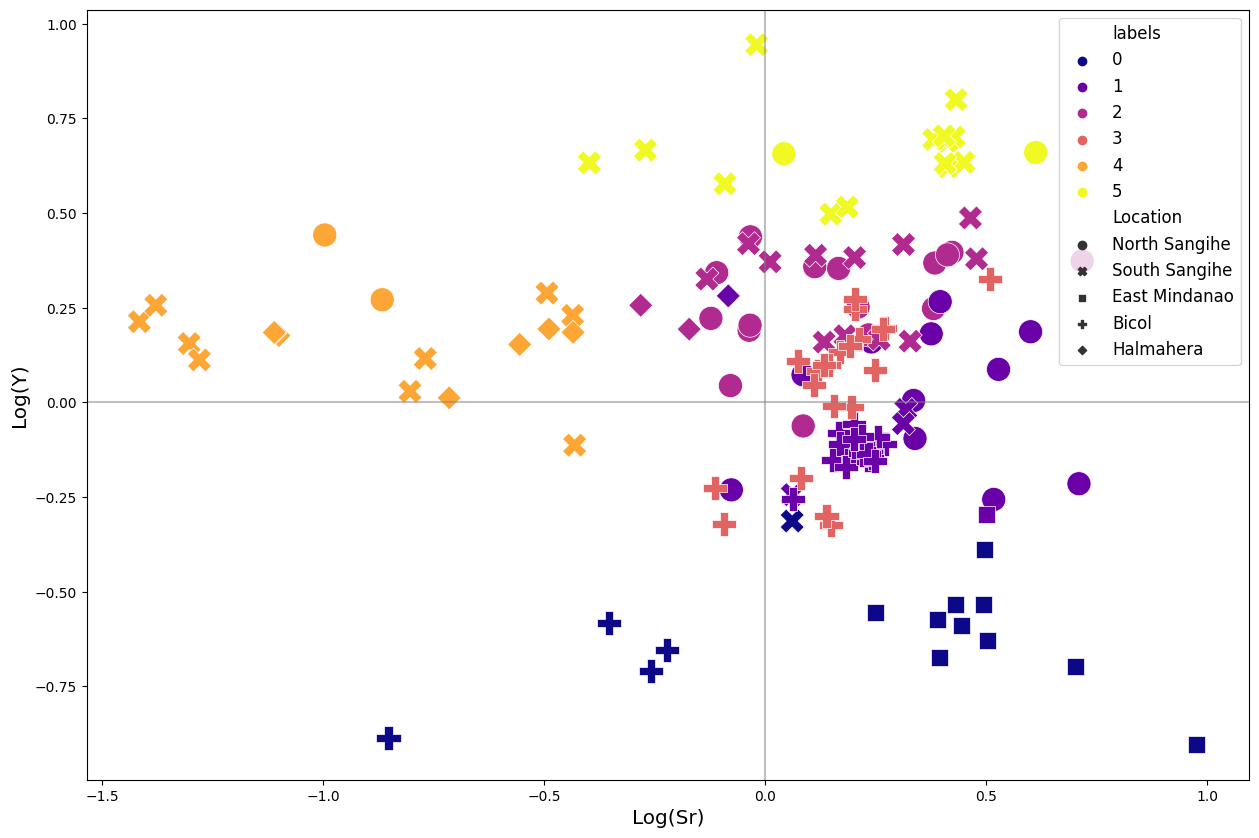

In [16]:
# original and labels

figx, ax = plt.subplots(figsize=(15, 10))
sns.scatterplot(data=pcIcAndOrginal,
                edgecolors="black",
                linewidth=0.5,
                x="Sr",
                y="Y",
                s=300,
                palette='plasma',
                style="Location",
                hue="labels")

# X = pcIcAndOrginal[elements].values

# A_pca_ica = pca.components_.T @ A.T

# elementX_index = elements.index('Sr')
# elementY_index = elements.index('Y')

# # Plot the IC directions projected onto the first two element
# mean_X_12 = np.mean(X[:, [elementX_index, elementY_index]], axis=0)
# for k in range(A_pca_ica.shape[1]):
#     component_direction = A_pca_ica[[elementX_index, elementY_index], k]
#     line = np.array([mean_X_12 - 3*component_direction, mean_X_12 + 3*component_direction])
#     plt.plot(line[:, 0], line[:, 1], label=f'IC {k+1}', linewidth=2)


plt.xlabel(f'Log(Sr)', fontsize="x-large")
plt.ylabel(f'Log(Y)', fontsize="x-large")
ax.axhline(y=0, color='gray', alpha=0.5)
ax.axvline(x=0, color='gray', alpha=0.5)
plt.legend(fontsize="large", loc=1)
plt.savefig(f'SrvsY_label_trace.svg')

## Gaussian Mixture Model

silhouette score GM: 0.2662097949267565


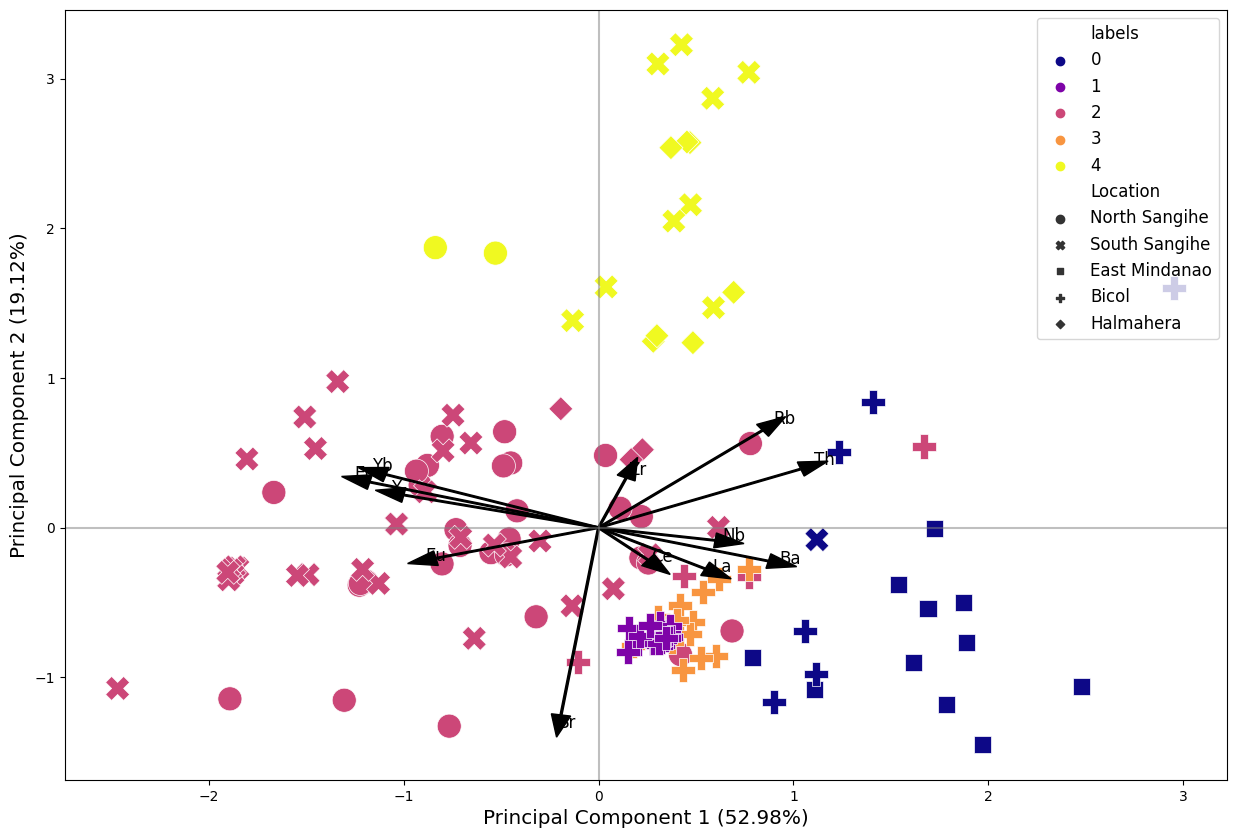

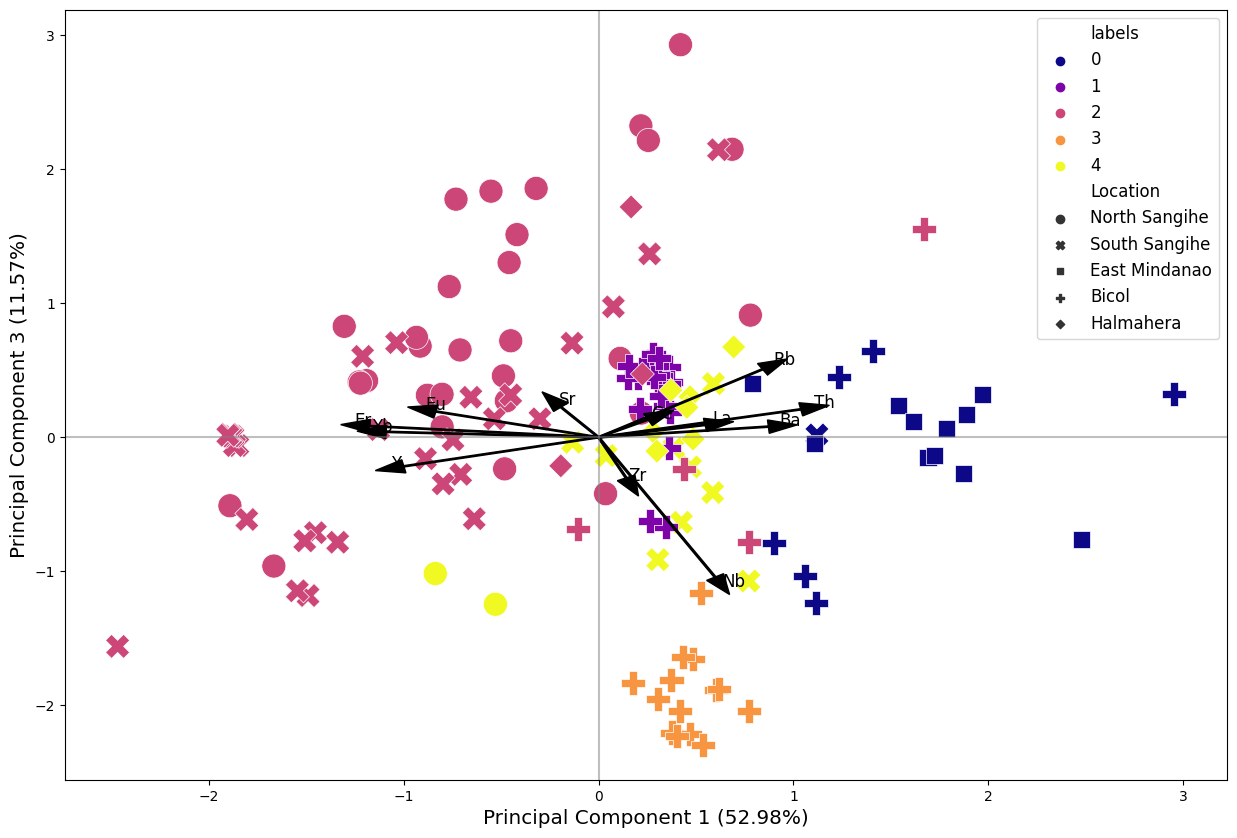

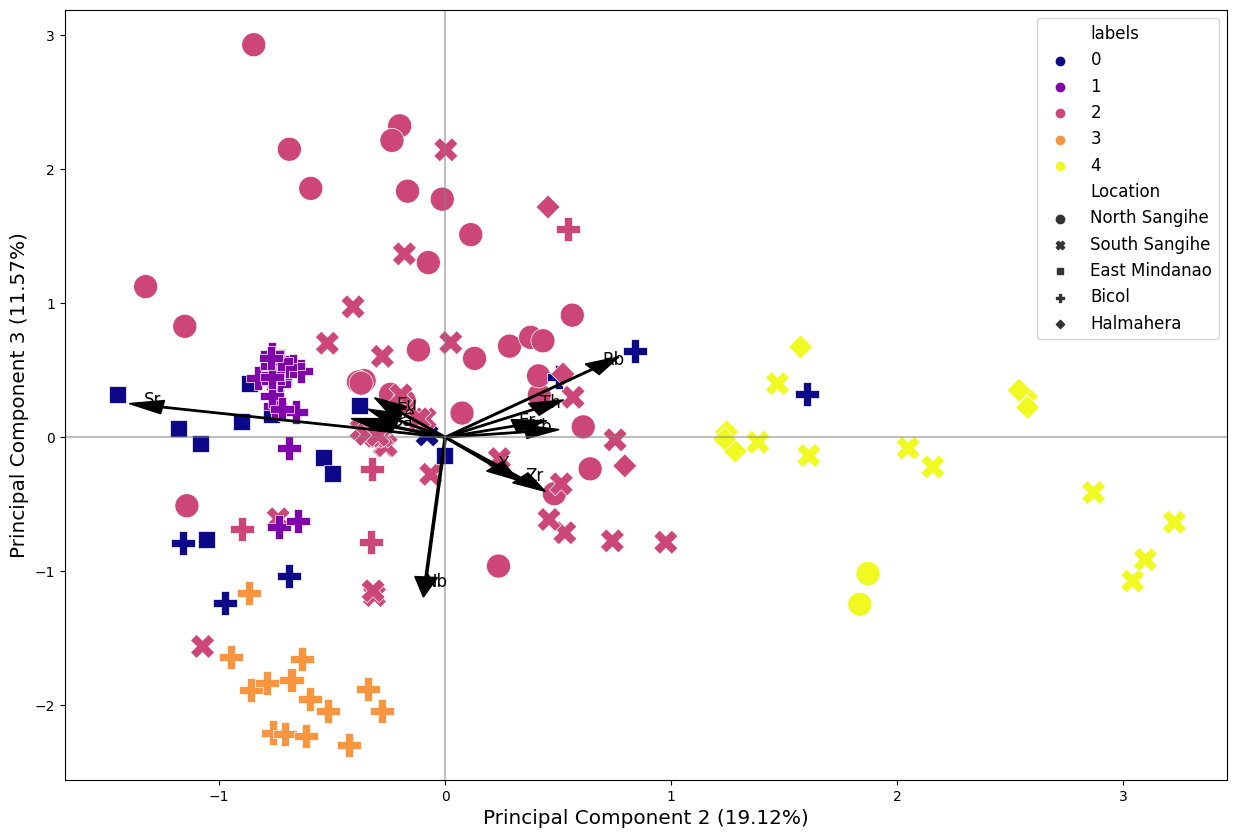

In [17]:
from sklearn.mixture import GaussianMixture

def gmm(principalComponentsDataframe, cluster, explainedVarianceRatio, ratio, frame, loadingVectors):
    X = principalComponentsDataframe.iloc[:, 0:3].values
    dataFrame = principalComponentsDataframe[frame]
    
    gm = GaussianMixture(init_params="k-means++", n_components=cluster, random_state=12, n_init=1,covariance_type='diag' )
    labels = gm.fit_predict(X)
    score = silhouette_score(X, labels)
    print(f'silhouette score GM: {score}')

    principalComponentsDataframe["labels"] = labels

    # Plot dataset
    fig, ax = plt.subplots(figsize=(15, 10))
    sns.scatterplot(x="PC1",
                    y="PC2",
                    edgecolors="black",
                    linewidth=0.5,
                    s=300,
                    data=principalComponentsDataframe,
                    hue="labels",
                    style="Location",
                    palette="plasma")
    plt.legend(fontsize="large", loc=1)
    plt.xlabel(f'Principal Component 1 ({explainedVarianceRatio[0]*100:.2f}%)', fontsize="x-large")
    plt.ylabel(f'Principal Component 2 ({explainedVarianceRatio[1]*100:.2f}%)', fontsize="x-large")
    ax.axhline(y=0, color='gray', alpha=0.5)
    ax.axvline(x=0, color='gray', alpha=0.5)
    for i, feature in enumerate(elements):
        plt.arrow(0,
                  0,
                  3 * loadingVectors[i, 0],
                  3 * loadingVectors[i, 1],
                  color='black',
                  width=0.01,
                  head_width=0.1)
        plt.text(3.2 * loadingVectors[i, 0],
                 3.2 * loadingVectors[i, 1],
                 feature,
                 fontsize="large")
    plt.savefig(f'KMC_trace_PC1_vs_PC2_{score}_{cluster}.svg')

    fig2, ax = plt.subplots(figsize=(15, 10))
    sns.scatterplot(x="PC1",
                    y="PC3",
                    edgecolors="black",
                    linewidth=0.5,
                    s=300,
                    data=principalComponentsDataframe,
                    hue="labels",
                    style="Location",
                    palette="plasma")
    plt.legend(fontsize="large", loc=1)
    plt.xlabel(f'Principal Component 1 ({explainedVarianceRatio[0]*100:.2f}%)', fontsize="x-large")
    plt.ylabel(f'Principal Component 3 ({explainedVarianceRatio[2]*100:.2f}%)', fontsize="x-large")
    ax.axhline(y=0, color='gray', alpha=0.5)
    ax.axvline(x=0, color='gray', alpha=0.5)
    for i, feature in enumerate(elements):
        plt.arrow(0,
                  0,
                  3 * loadingVectors[i, 0],
                  3 * loadingVectors[i, 2],
                  color='black',
                  width=0.01,
                  head_width=0.1)
        plt.text(3.2 * loadingVectors[i, 0],
                 3.2 * loadingVectors[i, 2],
                 feature,
                 fontsize="large")
    plt.savefig(f'KMC_trace_PC1_vs_PC3_{score}_{cluster}.svg')

    fig3, ax = plt.subplots(figsize=(15, 10))
    sns.scatterplot(x="PC2",
                    y="PC3",
                    edgecolors="black",
                    linewidth=0.5,
                    s=300,
                    data=principalComponentsDataframe,
                    hue="labels",
                    style="Location",
                    palette="plasma")
    plt.legend(fontsize="large", loc=1)
    plt.xlabel(f'Principal Component 2 ({explainedVarianceRatio[1]*100:.2f}%)', fontsize="x-large")
    plt.ylabel(f'Principal Component 3 ({explainedVarianceRatio[2]*100:.2f}%)', fontsize="x-large")
    ax.axhline(y=0, color='gray', alpha=0.5)
    ax.axvline(x=0, color='gray', alpha=0.5)
    for i, feature in enumerate(elements):
        plt.arrow(0,
                  0,
                  3 * loadingVectors[i, 1],
                  3 * loadingVectors[i, 2],
                  color='black',
                  width=0.01,
                  head_width=0.1)
        plt.text(3.2 * loadingVectors[i, 1],
                 3.2 * loadingVectors[i, 2],
                 feature,
                 fontsize="large")
    plt.savefig(f'KMC_trace_PC2_vs_PC3_{score}_{cluster}.svg')
    
    return principalComponentsDataframe
    
cluster = 5
labelDataframe = gmm(principalComponentsDataframe, cluster, explainedVarianceRatio, elements, frame, loadingVectors)

In [18]:
pcAndOriginal = pd.concat([labelDataframe, concatData[elements]], axis=1, join='inner')
pcIcAndOrginal = pd.concat([pcAndOriginal, pcIcAndOrginal[["IC1", "IC2", "IC3"]]], axis=1, join='inner')
pcIcAndOrginal

PC1       PC2       PC3       Location  Longitude  Latitude  \
0   -0.552136 -0.166807  1.836955  North Sangihe    125.800     4.500   
1   -0.458999 -0.074990  1.304177  North Sangihe    125.700     4.233   
2   -0.529301  1.834104 -1.246265  North Sangihe    125.716     3.866   
3   -0.878332  0.415956  0.313675  North Sangihe    125.583     3.783   
4   -0.418545  0.112699  1.512626  North Sangihe    125.583     3.783   
..        ...       ...       ...            ...        ...       ...   
133  0.693484  1.572232  0.674178      Halmahera    127.330     0.800   
134  0.224865  0.520912  0.472374      Halmahera    127.350     0.300   
135  0.299575  1.282749 -0.103452      Halmahera    127.350     0.300   
136  0.484314  1.235928 -0.013100      Halmahera    127.350     0.300   
137  0.167172  0.454837  1.719114      Halmahera    127.350     0.300   

                  AGE         Sample Name Island Arc  labels  ...        Eu  \
0    PLIOCENE [16735]  s_PJ-40-78 [16735]    Sangihe       2  ...  0.387568   
1    PLIOCENE [16735]  s_PJ-43-78 [16735]    Sangihe       2  ...  0.286866   
2    PLIOCENE [16735]  s_PJ-45-78 [16735]    Sangihe       4  ...  0.221200   
3    PLIOCENE [16735]    s_PBUANG [16735]    Sangihe       2  ...  0.257825   
4    PLIOCENE [16735]   s_PJ-5-78 [16735]    Sangihe       2  ...  0.314496   
..                ...                 ...        ...     ...  ...       ...   
133               NaN        s_GL [25001]  Halmahera       4  ... -0.028485   
134               NaN       s_MK1 [25001]  Halmahera       2  ...  0.134601   
135               NaN       s_MK2 [25001]  Halmahera       4  ... -0.077697   
136               NaN       s_MK3 [25001]  Halmahera       4  ... -0.107032   
137               NaN       s_MK4 [25001]  Halmahera       2  ...  0.076469   

           Er        Yb        Th        Nb        Zr         Y       IC1  \
0    0.308690  0.254873 -0.413153 -0.870201 -0.110410  0.181223 -0.556485   
1    0.292747  0.251508 -0.291449 -0.733261 -0.007072  0.169978 -0.393659   
2    0.470382  0.527006 -0.313693  0.053677  0.594235  0.271216  1.357815   
3    0.490972  0.485924 -0.516492 -0.490717  0.090548  0.437412 -0.132409   
4    0.308462  0.262250 -0.307910 -0.644128 -0.218868  0.159787 -0.227443   
..        ...       ...       ...       ...       ...       ...       ...   
133 -0.094079  0.037949  0.784148 -0.340112  0.059147  0.012113  1.651776   
134 -0.019706 -0.000321  0.431778 -0.323646 -0.025183  0.193586  0.527887   
135  0.080834  0.058451  0.417464 -0.146565  0.237111  0.194043  1.251243   
136 -0.095104  0.005134  0.388129 -0.136680  0.265484  0.185159  1.302985   
137 -0.064501  0.044833  0.498209 -0.950363  0.023572  0.281431  0.357409   

          IC2       IC3  
0   -0.369754  1.805738  
1   -0.342347  1.282580  
2   -1.426019 -1.148949  
3   -0.963614  0.311118  
4   -0.405981  1.503119  
..        ...       ...  
133 -0.238316  0.788791  
134 -0.081657  0.509626  
135 -0.424270 -0.016608  
136 -0.242169  0.076377  
137 -0.088386  1.747748  

[138 rows x 25 columns]

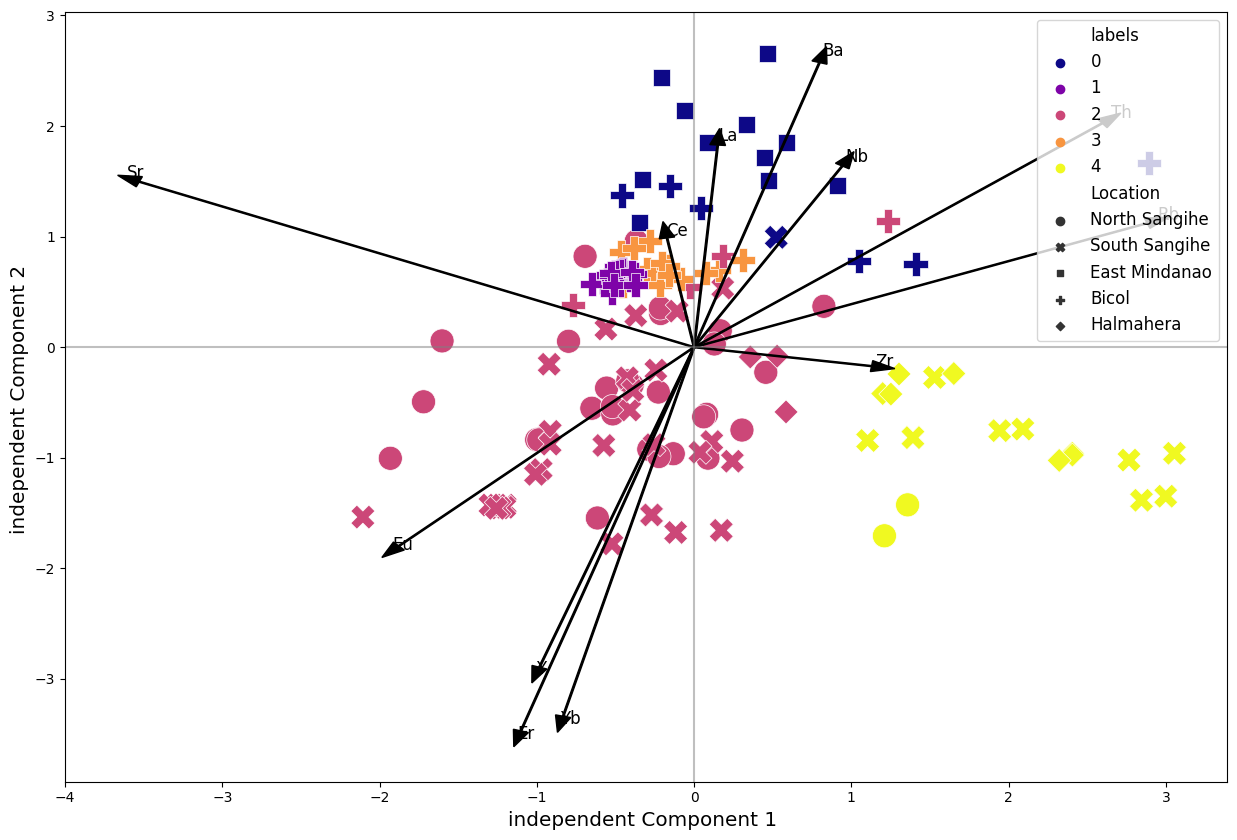

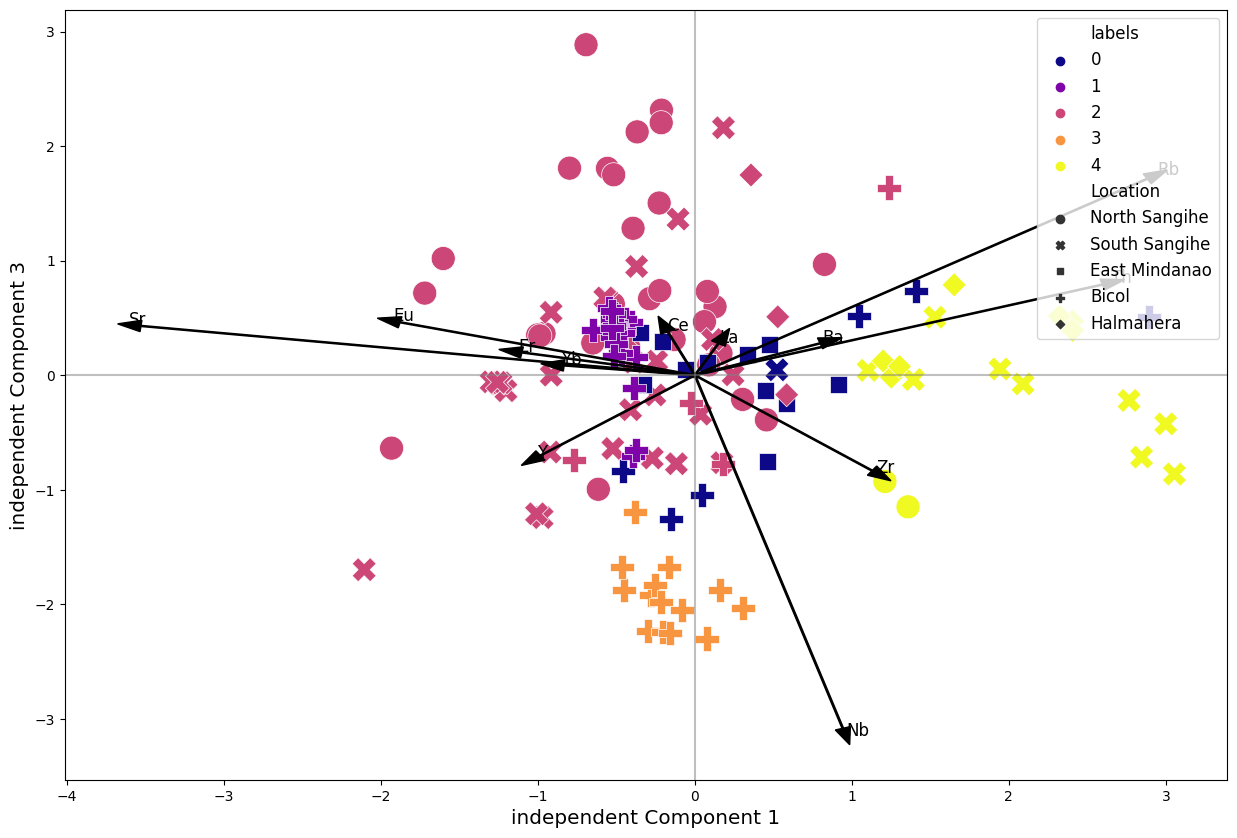

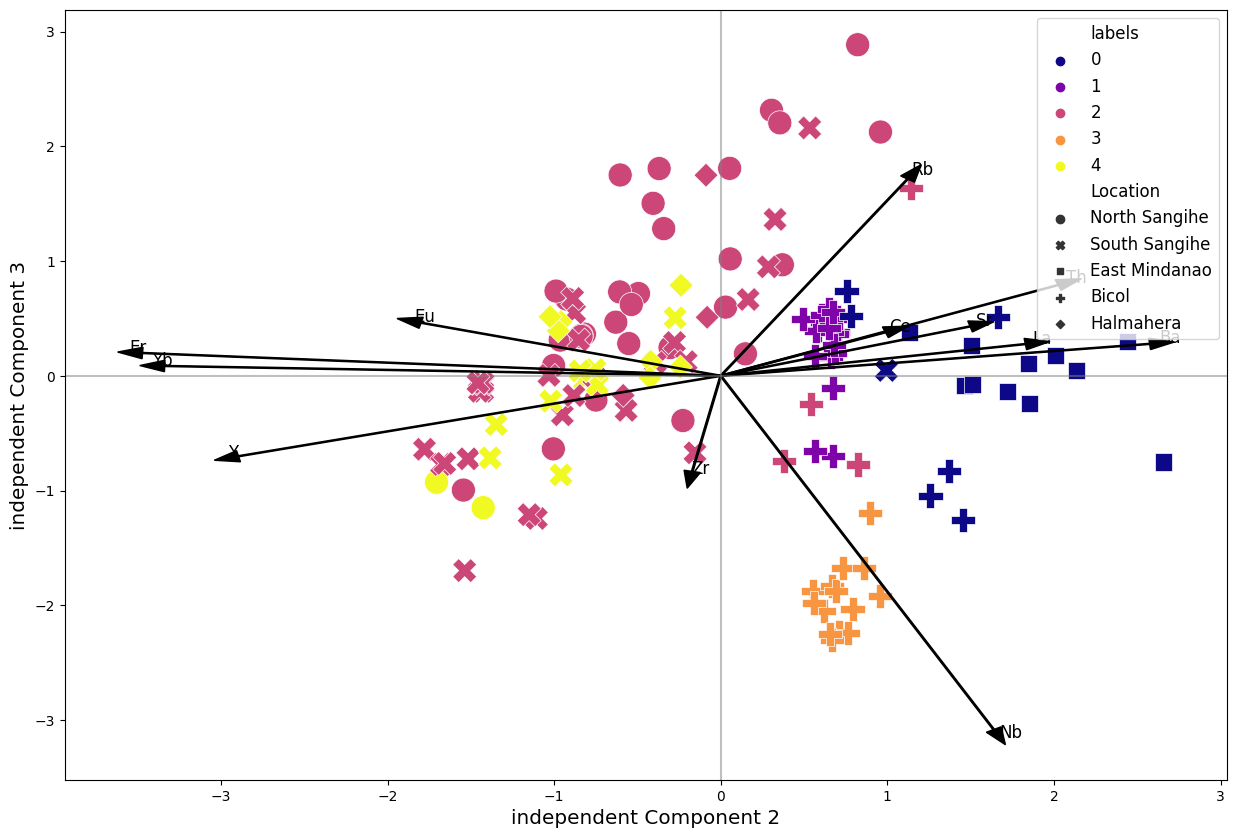

In [19]:
# ICA + Label
# IC1vsIC2
figx, ax = plt.subplots(figsize=(15, 10))
sns.scatterplot(data=pcIcAndOrginal,
                edgecolors="black",
                linewidth=0.5,
                x="IC1",
                y="IC2",
                s=300,
                palette='plasma',
                style="Location",
                hue="labels")
plt.legend(fontsize="large", loc=1)
plt.xlabel(f'independent Component 1 ', fontsize="x-large")
plt.ylabel(f'independent Component 2 ', fontsize="x-large")
for i, feature in enumerate(elements):
    plt.arrow(0,
              0,  
              arrow_multiplier * vectorData[i, 0],
              arrow_multiplier * vectorData[i, 1],
              color='black',
              width=0.01,
              head_width=0.1)
    plt.text(text_multiplier * vectorData[i, 0],
             text_multiplier * vectorData[i, 1],
             feature,
             fontsize="large")
ax.axhline(y=0, color='gray', alpha=0.5)
ax.axvline(x=0, color='gray', alpha=0.5)
plt.savefig(f'ICA_label_trace_{numberOfComponent}_1vs2.svg')
# IC1vsIC3
figy, ax = plt.subplots(figsize=(15, 10))
sns.scatterplot(data=pcIcAndOrginal,
                edgecolors="black",
                linewidth=0.5,
                x="IC1",
                y="IC3",
                s=300,
                palette='plasma',
                style="Location",
                hue="labels")
plt.legend(fontsize="large", loc=1)
plt.xlabel(f'independent Component 1', fontsize="x-large")
plt.ylabel(f'independent Component 3', fontsize="x-large")
for i, feature in enumerate(elements):
    plt.arrow(0,
              0,  
              arrow_multiplier * vectorData[i, 0],
              arrow_multiplier * vectorData[i, 2],
              color='black',
              width=0.01,
              head_width=0.1)
    plt.text(text_multiplier * vectorData[i, 0],
             text_multiplier * vectorData[i, 2],
             feature,
             fontsize="large")
ax.axhline(y=0, color='gray', alpha=0.5)
ax.axvline(x=0, color='gray', alpha=0.5)
plt.savefig(f'ICA_label_trace_{numberOfComponent}_1vs3.svg')
# IC2vsIC3
figz, ax = plt.subplots(figsize=(15, 10))
sns.scatterplot(data=pcIcAndOrginal,
                edgecolors="black",
                linewidth=0.5,
                x="IC2",
                y="IC3",
                s=300,
                palette='plasma',
                style="Location",
                hue="labels")
plt.legend(fontsize="large", loc=1)
plt.xlabel(f'independent Component 2', fontsize="x-large")
plt.ylabel(f'independent Component 3', fontsize="x-large")
for i, feature in enumerate(elements):
    plt.arrow(0,
              0,  
              arrow_multiplier * vectorData[i, 1],
              arrow_multiplier * vectorData[i, 2],
              color='black',
              width=0.01,
              head_width=0.1)
    plt.text(text_multiplier * vectorData[i, 1],
             text_multiplier * vectorData[i, 2],
             feature,
             fontsize="large")
ax.axhline(y=0, color='gray', alpha=0.5)
ax.axvline(x=0, color='gray', alpha=0.5)
plt.savefig(f'ICA_label_trace_{numberOfComponent}_2vs3.svg')

In [20]:
# Define a mapping of Location categories to symbols
location_symbol_mapping = {
    'Sangihe': 'circle',
    'East Philippine': 'square',
    'Halmahera': 'diamond',
}

# Apply the mapping to the 'Location' column
pcIcAndOrginal['location_symbol'] = pcIcAndOrginal['Island Arc'].map(location_symbol_mapping)

arrow_multiplier = 9
text_multiplier = 9.2

# Create 3D scatter plot
fig = go.Figure()

# Scatter plot for IC1, IC2, and IC3 with different symbols based on "Location"
fig.add_trace(go.Scatter3d(
    x=pcIcAndOrginal['IC1'],
    y=pcIcAndOrginal['IC2'],
    z=pcIcAndOrginal['IC3'],
    mode='markers',
    marker=dict(
        size=8,
        color=pcIcAndOrginal['labels'].astype('category').cat.codes,  # Color by 'Location'
        colorscale='ylgnbu',  # Color scale
        opacity=0.8,
        symbol=pcIcAndOrginal['location_symbol'],  # Use mapped symbols for locations
    ),
    text=pcIcAndOrginal['Island Arc'],  # Text when hovering over points
    hoverinfo='text',
    name='Data Points',  # Name for the legend
))

# Add lines for each feature with a legend
for i, feature in enumerate(elements):
    fig.add_trace(go.Scatter3d(
        x=[0, arrow_multiplier * vectorData[i, 0]],  # Line from origin to scaled vector
        y=[0, arrow_multiplier * vectorData[i, 1]],  # Line from origin to scaled vector
        z=[0, arrow_multiplier * vectorData[i, 2]],  # Line from origin to scaled vector
        mode='lines',
        line=dict(color='black', width=4),  # Customize line color and width
        hoverinfo='none',  # Disable hover info for lines
        showlegend=True,
        name=feature,  # Feature name for the legend
    ))
    # Add feature names as text labels
    fig.add_trace(go.Scatter3d(
        x=[text_multiplier * vectorData[i, 0]],
        y=[text_multiplier * vectorData[i, 1]],
        z=[text_multiplier * vectorData[i, 2]],
        mode='text',
        text=[feature],
        showlegend=False,
    ))

# Customize layout with legend
fig.update_layout(
    scene=dict(
        xaxis_title='Independent Component 1',
        yaxis_title='Independent Component 2',
        zaxis_title='Independent Component 3',
    ),
    margin=dict(l=0, r=0, b=0, t=0),
    hovermode='closest',
    legend=dict(
        title='Legend',
        x=0.02, y=0.98,
        bgcolor='rgba(255, 255, 255, 0.8)',
    ),
    showlegend=False,
)

# Show plot
display(fig)

## Map

In [21]:
def transform_latitude(lat):
    if lat < -6:
        return abs(lat)
    return lat

pcIcAndOrginal['Latitude'] = pcIcAndOrginal['Latitude'].apply(transform_latitude)

# Create geometry column with Point objects
pcIcAndOrginal['geometry'] = [Point(xy) for xy in zip(pcIcAndOrginal['Longitude'], pcIcAndOrginal['Latitude'])]

# Create a GeoDataFrame
geoDataframe = gpd.GeoDataFrame(pcIcAndOrginal, geometry='geometry')

# Set CRS to EPSG:4326 (WGS 84)
geoDataframe.set_crs(epsg=4326, inplace=True)

# Initialize a Folium map centered at the average latitude and longitude
map_center = [geoDataframe['Latitude'].mean(), geoDataframe['Longitude'].mean()]

# Gaussian Mixture Model Labels
m = folium.Map(location=map_center, zoom_start=5, tiles=None)

# Add Esri World Terrain basemap
folium.TileLayer('Esri.WorldTerrain').add_to(m)

# Create a color scale
color_scale = cm.LinearColormap(
    colors=['blue', 'green', 'yellow', 'orange', 'red'],  # Define color gradient
    vmin=geoDataframe['labels'].min(),  # Minimum value for scaling
    vmax=geoDataframe['labels'].max()   # Maximum value for scaling
)

# Function to create gradient circle marker
def create_gradient_circle(value, scale):
    color = scale(value)
    return f"""
    <div style="
        width: 20px; 
        height: 20px; 
        border-radius: 50%; 
        background: radial-gradient(circle, {color} 0%, rgba(255,255,255,0) 90%);
        border: 1px solid black;
    "></div>
    """

# Add markers with continuous color scale
for idx, row in geoDataframe.iterrows():
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=f"{row['Sample Name']}: {row['Location']}",
        icon=folium.DivIcon(
            html=create_gradient_circle(row['labels'], color_scale)
        )
    ).add_to(m)

# Add color scale legend to the map
color_scale.add_to(m)

# Display the map inline
display(m)


/opt/conda/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:131: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.



In [22]:
# IC1
x = folium.Map(location=map_center, zoom_start=5, tiles=None)

# Add Esri World Terrain basemap
folium.TileLayer('Esri.WorldTerrain').add_to(x)

# Create a color scale
color_scale = cm.LinearColormap(
    colors=['blue', 'green', 'yellow', 'red'],  # Define color gradient
    vmin=geoDataframe['IC1'].min(),  # Minimum value for scaling
    vmax=geoDataframe['IC1'].max()   # Maximum value for scaling
)

# Function to create gradient circle marker
def create_gradient_circle(value, scale):
    color = scale(value)
    return f"""
    <div style="
        width: 20px; 
        height: 20px; 
        border-radius: 50%; 
        background: radial-gradient(circle, {color} 0%, rgba(255,255,255,0) 70%);
        border: 1px solid black;
    "></div>
    """

# Add markers with continuous color scale
for idx, row in geoDataframe.iterrows():
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=f"{row['Sample Name']}: {row['Location']}",
        icon=folium.DivIcon(
            html=create_gradient_circle(row['IC1'], color_scale)
        )
    ).add_to(x)

# Add color scale legend to the map
color_scale.add_to(x)

# Display the map inline
display(x)

In [23]:
# IC 2
l = folium.Map(location=map_center, zoom_start=5, tiles=None, )

# Add Esri World Terrain basemap
folium.TileLayer('Esri.WorldTerrain').add_to(l)

# Create a color scale
color_scale = cm.LinearColormap(
    colors=['blue', 'green', 'yellow', 'red'],  # Define color gradient
    vmin=geoDataframe['IC2'].min(),  # Minimum value for scaling
    vmax=geoDataframe['IC2'].max()   # Maximum value for scaling
)

# Function to create gradient circle marker
def create_gradient_circle(value, scale):
    color = scale(value)
    return f"""
    <div style="
        width: 20px; 
        height: 20px; 
        border-radius: 50%; 
        background: radial-gradient(circle, {color} 0%, rgba(255,255,255,0) 70%);
        border: 1px solid black;
    "></div>
    """

# Add markers with continuous color scale
for idx, row in geoDataframe.iterrows():
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=f"{row['Sample Name']}: {row['Location']}",
        icon=folium.DivIcon(
            html=create_gradient_circle(row['IC2'], color_scale)
        )
    ).add_to(l)

# Add color scale legend to the map
color_scale.add_to(l)

# Display the map inline
display(l)

In [24]:
# IC 3
k = folium.Map(location=map_center, zoom_start=5, tiles=None)

# Add Esri World Terrain basemap
folium.TileLayer('Esri.WorldTerrain').add_to(k)

# Create a color scale
color_scale = cm.LinearColormap(
    colors=['blue', 'green', 'yellow', 'red'],  # Define color gradient
    vmin=geoDataframe['IC3'].min(),  # Minimum value for scaling
    vmax=geoDataframe['IC3'].max()   # Maximum value for scaling
)

# Function to create gradient circle marker
def create_gradient_circle(value, scale):
    color = scale(value)
    return f"""
    <div style="
        width: 20px; 
        height: 20px; 
        border-radius: 50%; 
        background: radial-gradient(circle, {color} 0%, rgba(255,255,255,0) 70%);
        border: 1px solid black;
    "></div>
    """

# Add markers with continuous color scale
for idx, row in geoDataframe.iterrows():
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=f"{row['Sample Name']}: {row['Location']}",
        icon=folium.DivIcon(
            html=create_gradient_circle(row['IC3'], color_scale)
        )
    ).add_to(k)

# Add color scale legend to the map
color_scale.add_to(k)

# Display the map inline
display(k)